Emigration and Socio-Economic Indicators, Exploratory Data Analysis
-----
Author: Luciano Raso [ www.lraso.com ]

In [22]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
from IPython.display import Image

pal = sns.color_palette()
plt.style.use('ggplot')
%config InlineBackend.figure_format='retina'

matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)


### Business / Policy Question
---

Migration is a high in the political and policy agenda. Can we predict the next migration wave?

### User
---

The analysis has been carried out for the ***[Pacte Lab](https://www.pacte-grenoble.fr/)*** of Grenoble. <br> 
The results are freely accessible, reproducible, and reusable. They can be used, for example, by policy makers of both origin and destination countries.

### Objective
---

__
Identify a predictive model of migration fluxes, based on indicators produced or collected by the World Bank. 
__


Diffrent theories of migration produced different models to explain the flow of people from one location to another. 
See the infographic below, taken from the website of the [European Commission](https://ec.europa.eu/knowledge4policy/publication/why-do-people-migrate-infographic_en), or the [scientific literature](https://www.taylorfrancis.com/books/e/9781351926751/chapters/10.4324%2F9781315252001-10).

Here we take an alternative approach: we try to identify a relation between the international data on migration data and  the available socio-economic indicators, collected by the World Bank, aggregated at the country level. We focus initially on emigration data only. <br>

In this notebook I carry out a preliminary exploratory data analysis. A statistcal model between emigration and the socio-economic indicators is presented [here](https://github.com/luciofaso/migration_analysis).

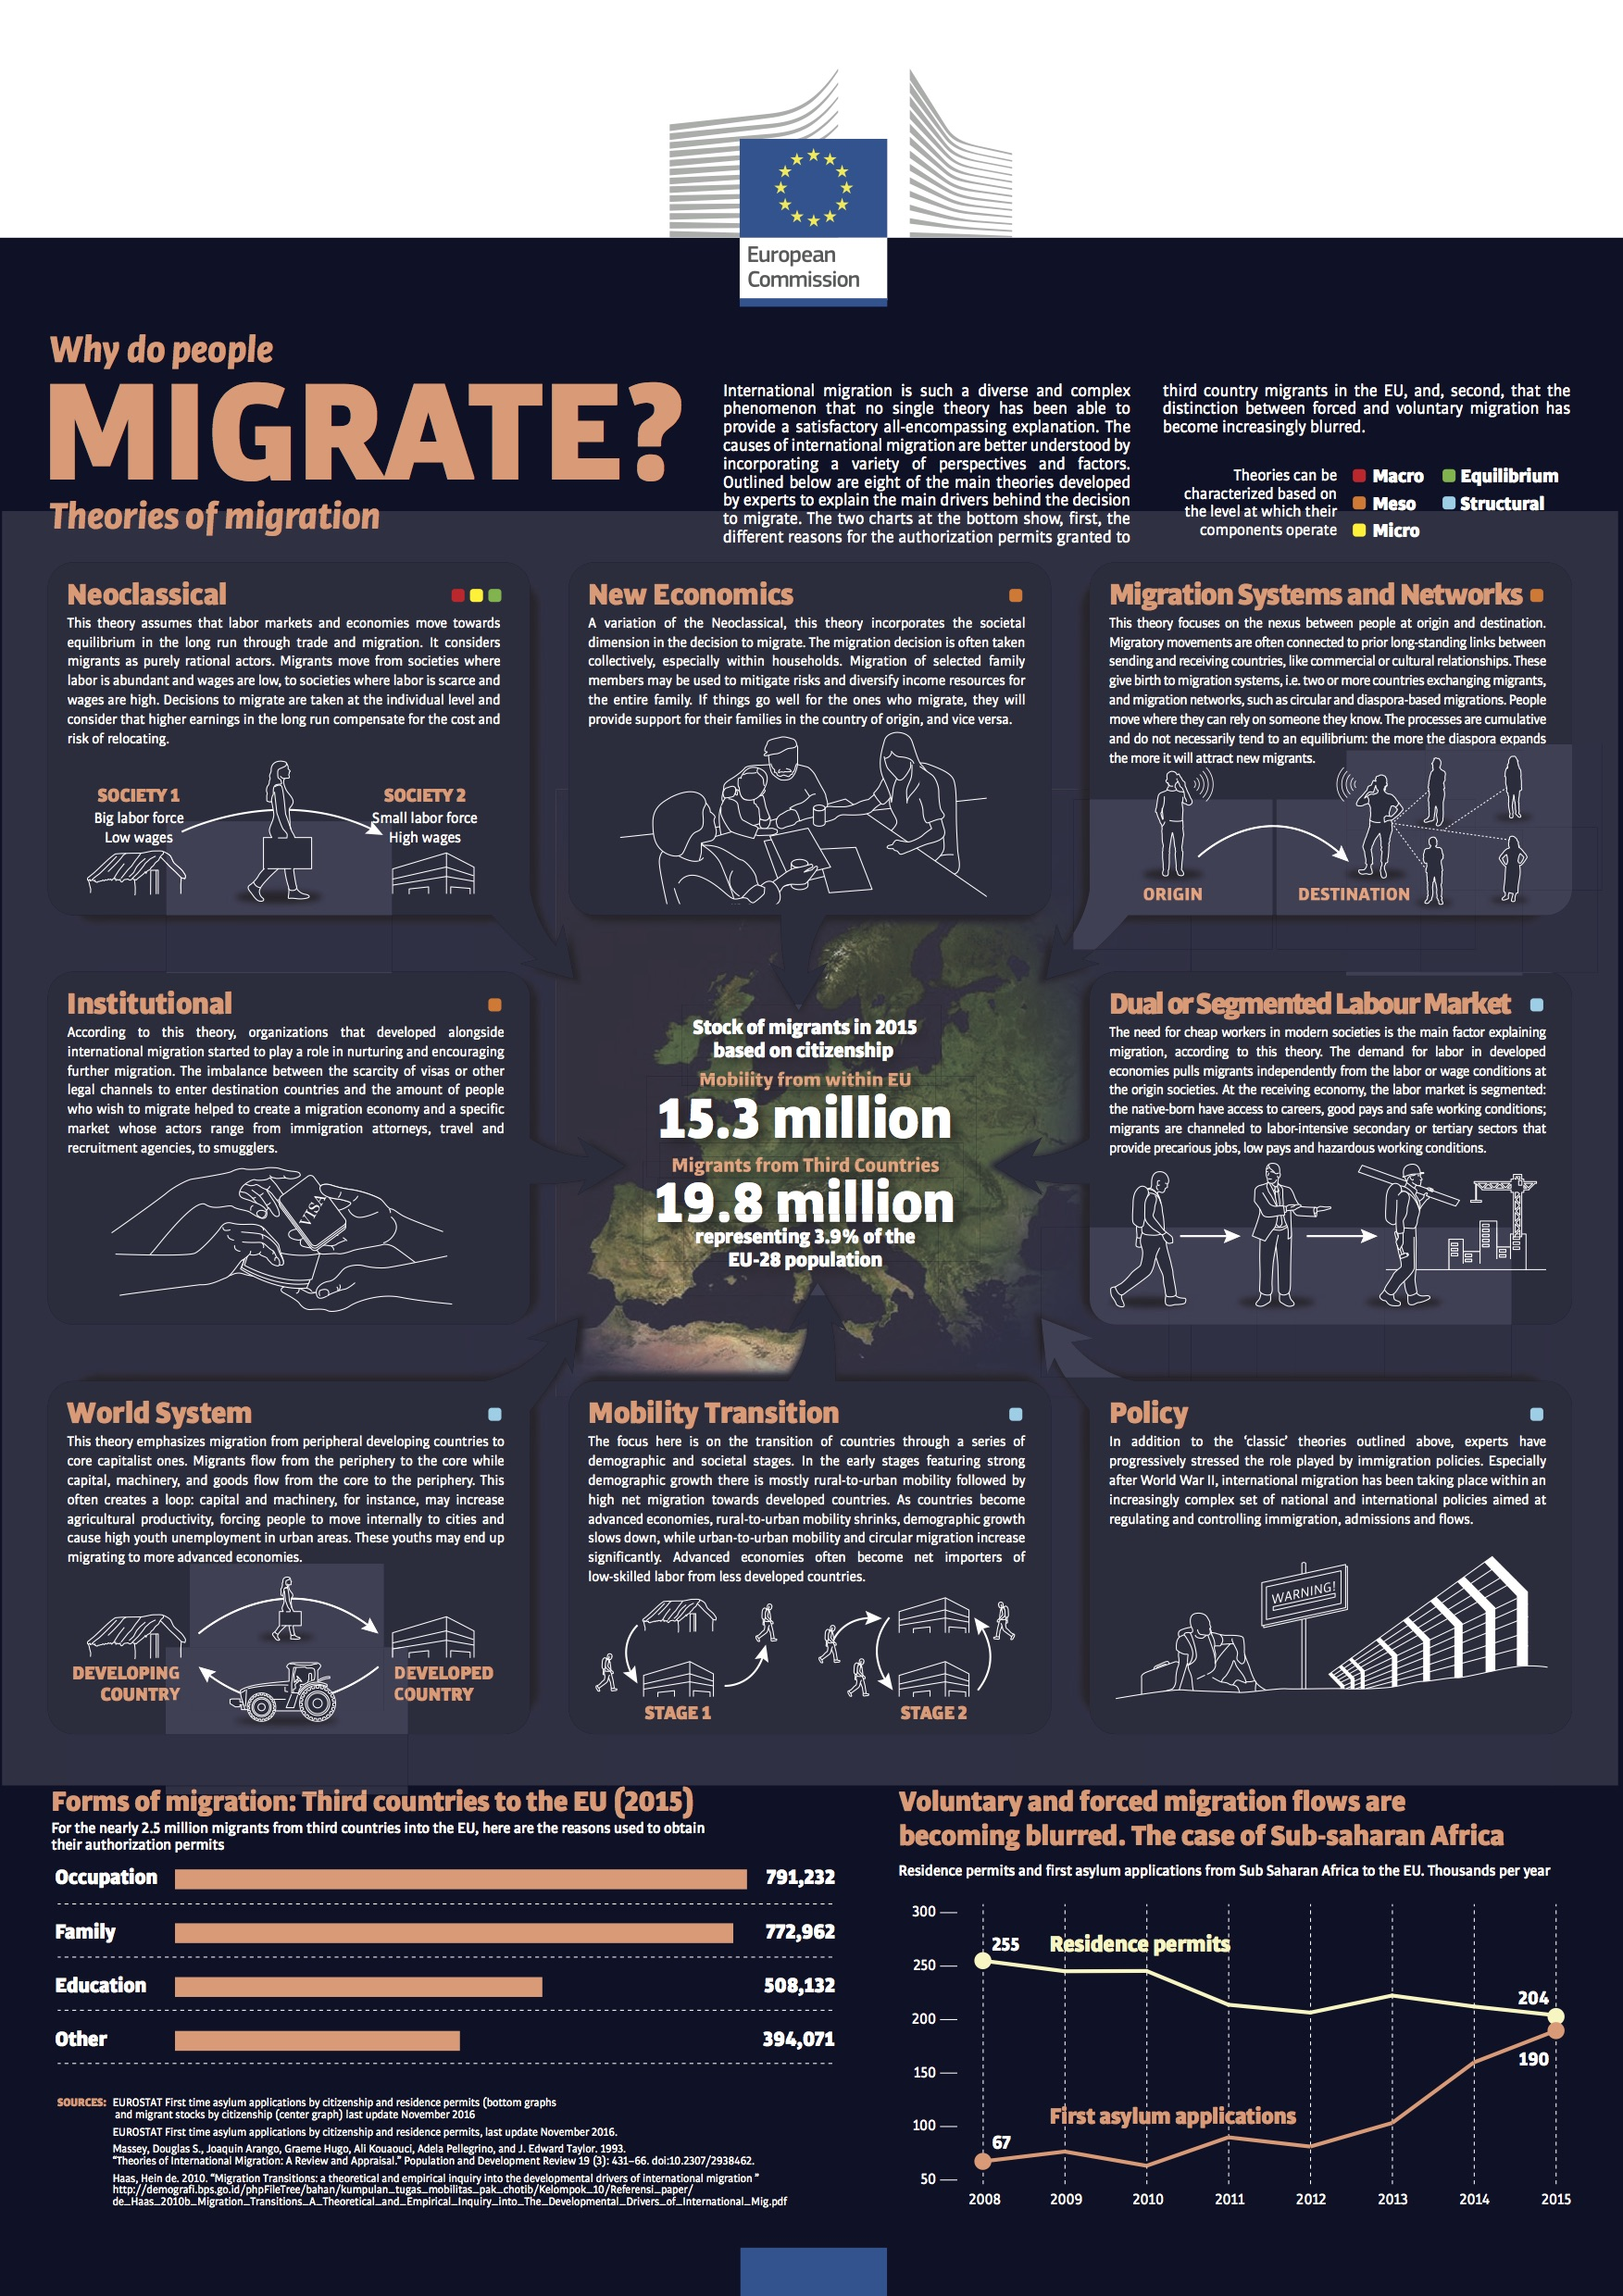

In [79]:
Image("figures/theoriesofmigration.jpg",width=1000)

### Data availability
___

Migration data and and World Bank indicators data are free and available at http://databank.worldbank.org/data/home.aspx

### Load and wrangle migration data

In [24]:
df_migr_raw = pd.read_csv('data/migration_data.csv') # load migration data

In [25]:
df_migr_raw.head()

Country Origin Name Country Origin Code Migration by Gender Name  \
0         Afghanistan                 AFG                   Female   
1         Afghanistan                 AFG                   Female   
2         Afghanistan                 AFG                   Female   
3         Afghanistan                 AFG                   Female   
4         Afghanistan                 AFG                   Female   

  Migration by Gender Code Country Dest Name Country Dest Code 1960 [1960]  \
0                      FEM       Afghanistan               AFG           0   
1                      FEM           Albania               ALB           0   
2                      FEM           Algeria               DZA          22   
3                      FEM    American Samoa               ASM           0   
4                      FEM           Andorra               AND           0   

  1970 [1970] 1980 [1980] 1990 [1990] 2000 [2000]  
0           0           0           0           0  
1           0           0           0           0  
2           8           6           5           4  
3           0           0           0           0  
4           0           0           2           3

The table presents migration flows in terms of number of people, by 
1. Country of Origin
2. Gender
3. Country of Destination
4. Decade, from 1960 to 2000

We select the relevant columns, rename them, and rearrange the data: specifically, we will move the decade columns as entry, such that each row is representative of a single observation.

In [85]:
df_migr = df_migr_raw[['Country Origin Code', 'Migration by Gender Code', 'Country Dest Code', 
             '1960 [1960]', '1970 [1970]', '1980 [1980]', '1990 [1990]','2000 [2000]']]
df_migr.columns=['Origin','Gender','Destination','1960','1970','1980','1990','2000']

# rearrange data
df_migr_m = df_migr.melt(id_vars=['Origin','Gender','Destination'],var_name='Year')
df_migr_m['Year'] = df_migr_m['Year'].astype('int64')

We focus on the total migration, i.e. at this stage we do not consider the gender issue.

In [28]:
df_migr_tot = df_migr_m[df_migr_m['Gender']=='TOT']
del df_migr_tot['Gender']

In [86]:
df_migr_tot.value = pd.to_numeric(df_migr_tot.value, errors='coerce')
df_migr_tot.head()

/Users/lraso/anaconda/lib/python3.5/site-packages/pandas/core/generic.py:2999: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Origin Destination  Year  value
462    AFG         AFG  1960    0.0
463    AFG         ALB  1960    0.0
464    AFG         DZA  1960   41.0
465    AFG         ASM  1960    0.0
466    AFG         AND  1960    0.0

#### Emigration Data
In this notebook we analyse emigration data only. Therefore the bilateral migration 
database is aggregated on the Country of Origin and Year. 

In [90]:
emigration = df_migr_tot.groupby(['Origin','Year']).sum().reset_index()
emigration.columns = ['CountryCode', 'Year', 'Emigration, total']

We now have the data in the form that we need for the analysis (see table below).

In [91]:
emigration.head()

CountryCode  Year  Emigration, total
0         ABW  1960             1622.0
1         ABW  1970             1041.0
2         ABW  1980             4280.0
3         ABW  1990             9202.0
4         ABW  2000            10059.0

### Load and wrangle World Bank indicators data

In [99]:
df_indicators = pd.read_csv('data/indicators.csv') # load data

In [100]:
def select_years (df,  years, column_dates):
    """" Select the years from a larger datasests """

    df_out = pd.DataFrame()
    for year in years:
        df_year = df [df[column_dates]== year]
        df_out = df_out.append(df_year,ignore_index=True)
    return(df_out)    

In [101]:
# delete non-relevant information
del df_indicators['IndicatorCode']
df_indicators.columns = ['Country','CountryCode','Indicator','Year','Value']

# select years corresponding to the migration database  
years_migration = df_migr_m['Year'].unique()
years_migr_int = [int(year) for year in years_migration]
df_indicators_years = select_years (df_indicators, years_migr_int ,'Year')

# reshape dataframe
df_indicators_years_pivot = df_indicators_years.\
    pivot_table(index=['CountryCode','Year'],columns='Indicator',values='Value')
df_indicators_years_pivot = df_indicators_years_pivot.reset_index()

In [102]:
df_indicators_years_pivot.head()

Indicator CountryCode  Year  \
0                 ABW  1960   
1                 ABW  1970   
2                 ABW  1980   
3                 ABW  1990   
4                 ABW  2000   

Indicator  ARI treatment (% of children under 5 taken to a health provider)  \
0                                                        NaN                  
1                                                        NaN                  
2                                                        NaN                  
3                                                        NaN                  
4                                                        NaN                  

Indicator  Access to electricity (% of population)  \
0                                              NaN   
1                                              NaN   
2                                              NaN   
3                                         81.13573   
4                                         85.41120   

Indicator  Access to electricity, rural (% of rural population)  \
0                                                        NaN      
1                                                        NaN      
2                                                        NaN      
3                                                   67.71096      
4                                                   72.26502      

Indicator  Access to electricity, urban (% of urban population)  \
0                                                        NaN      
1                                                        NaN      
2                                                        NaN      
3                                                  94.390286      
4                                                 100.000000      

Indicator  Access to non-solid fuel (% of population)  \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                                 NaN   
4                                                 NaN   

Indicator  Adjusted net enrolment rate, primary, both sexes (%)  \
0                                                        NaN      
1                                                        NaN      
2                                                        NaN      
3                                                        NaN      
4                                                  98.253593      

Indicator  Adjusted net enrolment rate, primary, female (%)  \
0                                                       NaN   
1                                                       NaN   
2                                                       NaN   
3                                                       NaN   
4                                                 97.992264   

Indicator  Adjusted net enrolment rate, primary, male (%)  \
0                                                     NaN   
1                                                     NaN   
2                                                     NaN   
3                                                     NaN   
4                                               98.509232   

Indicator                          ...                            \
0                                  ...                             
1                                  ...                             
2                                  ...                             
3                                  ...                             
4                                  ...                             

Indicator  Women who believe a husband is justified in beating his wife when she argues with him (%)  \
0                                                        NaN                                           
1                                                        NaN                                      

#### Add region
The region to wich the country belongs can be a relevant feature in estimating emigration. This is contained in the "countries" table of the worldbank database, which must be imported and merged with the "indicators", table.

In [103]:
# load country data
df_country = pd.read_csv('data/countries.csv')
# select relevant columns
df_country = df_country[['CountryCode','Region']]
# merge with indicators data
df_indicators_years_pivot = df_indicators_years_pivot\
    .merge(df_country,how='left',on=['CountryCode'])

### Merge migration and worldbank datasets

In [104]:
# merge data-sets
data_set = pd.merge(df_indicators_years_pivot,emigration,on=['CountryCode','Year'])

In [105]:
# add relative Emigration
data_set['Emigration, % pop'] = \
    data_set['Emigration, total']/data_set['Population, total']*100

## Exploratory Data Analysis

#### Emigration over time
The plot below show the absolute and relative emigration over the period for which we have data.

Text(0,0.5,'Emigration, total')

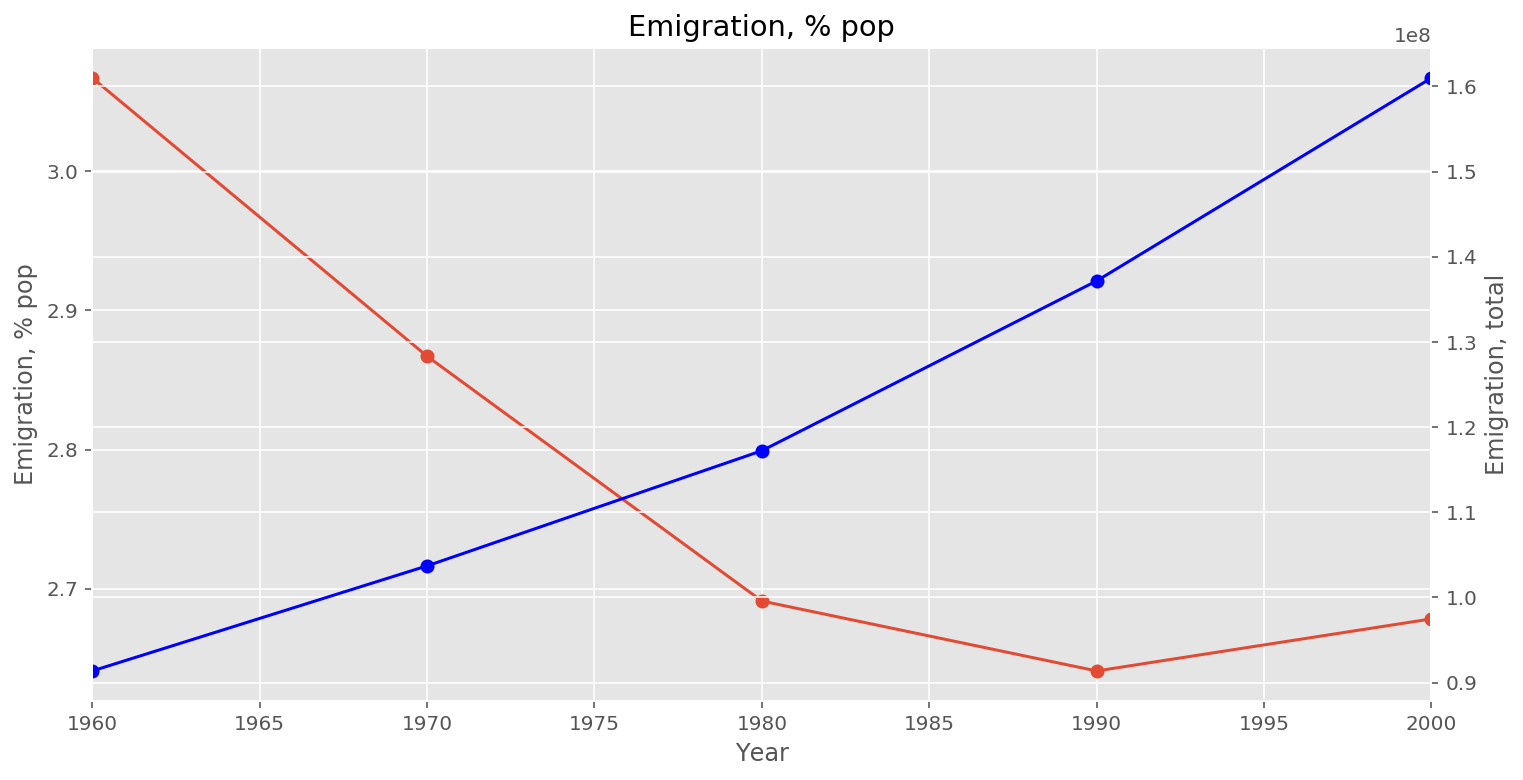

In [92]:
world_emigr_year = data_set.groupby(['Year']).sum()[['Emigration, total','Population, total']]
world_emigr_year['Emigration, % pop'] = \
    world_emigr_year['Emigration, total']/world_emigr_year['Population, total']*100
ax1= world_emigr_year['Emigration, % pop'].plot(marker='o',title='Emigration, % pop')
ax1.set_ylabel('Emigration, % pop')
ax2 = ax1.twinx()
world_emigr_year['Emigration, total'].plot(ax=ax2,color='blue',marker='o',title=False)
ax2.set_ylabel('Emigration, total')


______
The plot above shows that the absolute amoung of people emigrating has increase of about 60% in 40 years. The relative proportion of emigration, over the total population, instead, shows a general decline. 

#### Emigration by region, over time
The plot below shows the trend over time of relative emigration by region. 

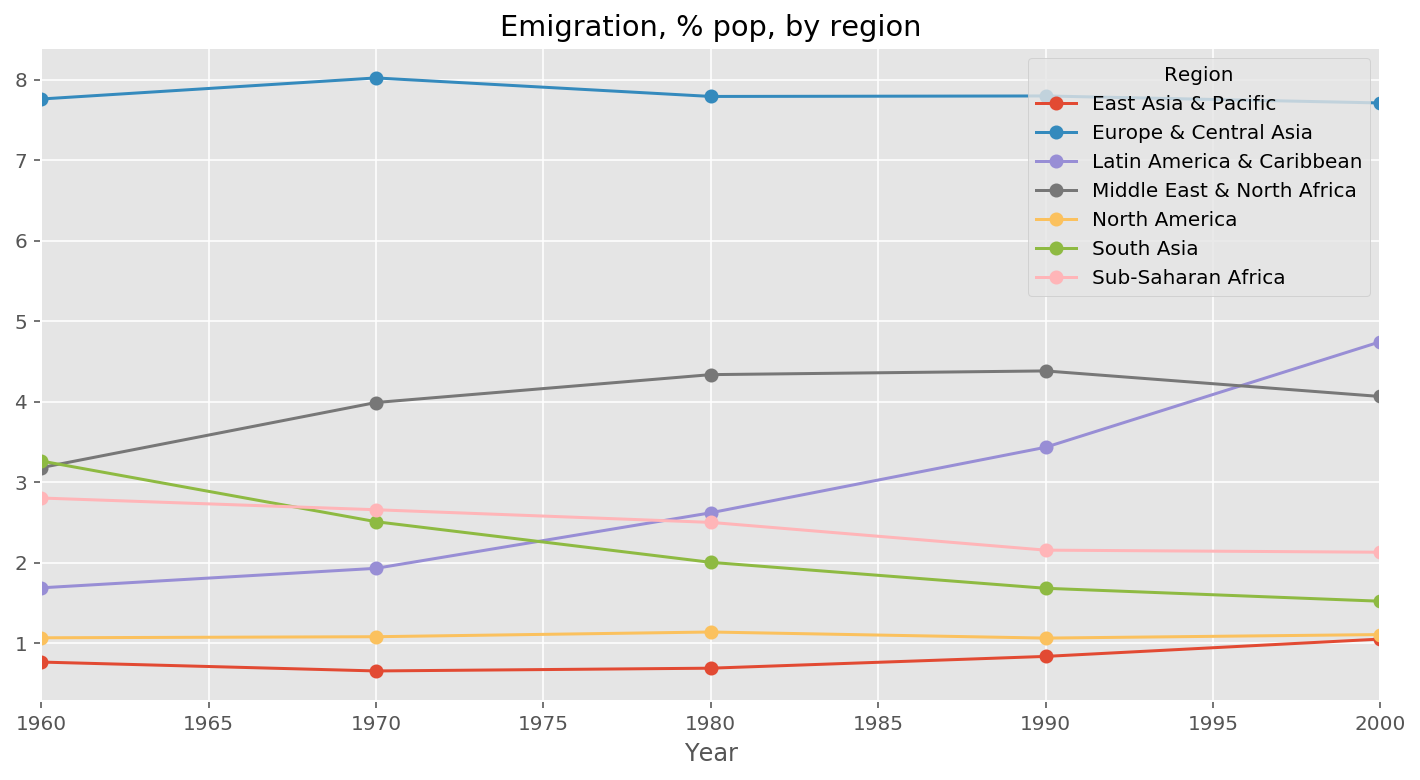

In [106]:
regions_emigr_year = data_set.groupby(['Year','Region']).sum()[['Emigration, total','Population, total']]
regions_emigr_year['Emigration, % pop'] = \
    regions_emigr_year['Emigration, total']/regions_emigr_year['Population, total']*100
#data_set.pivot_table(columns='Region',index='Year',values='Emigration, % pop').plot(marker='o',title='Emigration, % pop')
regions_emigr_year = regions_emigr_year.pivot_table(columns='Region',index='Year',values='Emigration, % pop' )
regions_emigr_year.plot(marker='o',title='Emigration, % pop, by region')

_____
Europe and Central Asia much larger percentage of emigration. East-Asia very low. Steady over the year. Middle East and North Africa, and more xx Latin America and 

#### Emigration vs Population and GDP
We cross now the information on emigration with population size and GDP, by country. We will identify the key variables in the model.  

The amount of people emigrating increase xxx. 
Clearly, more people, more emigration. 
All economic theories stresses the importance of the economic factor. 

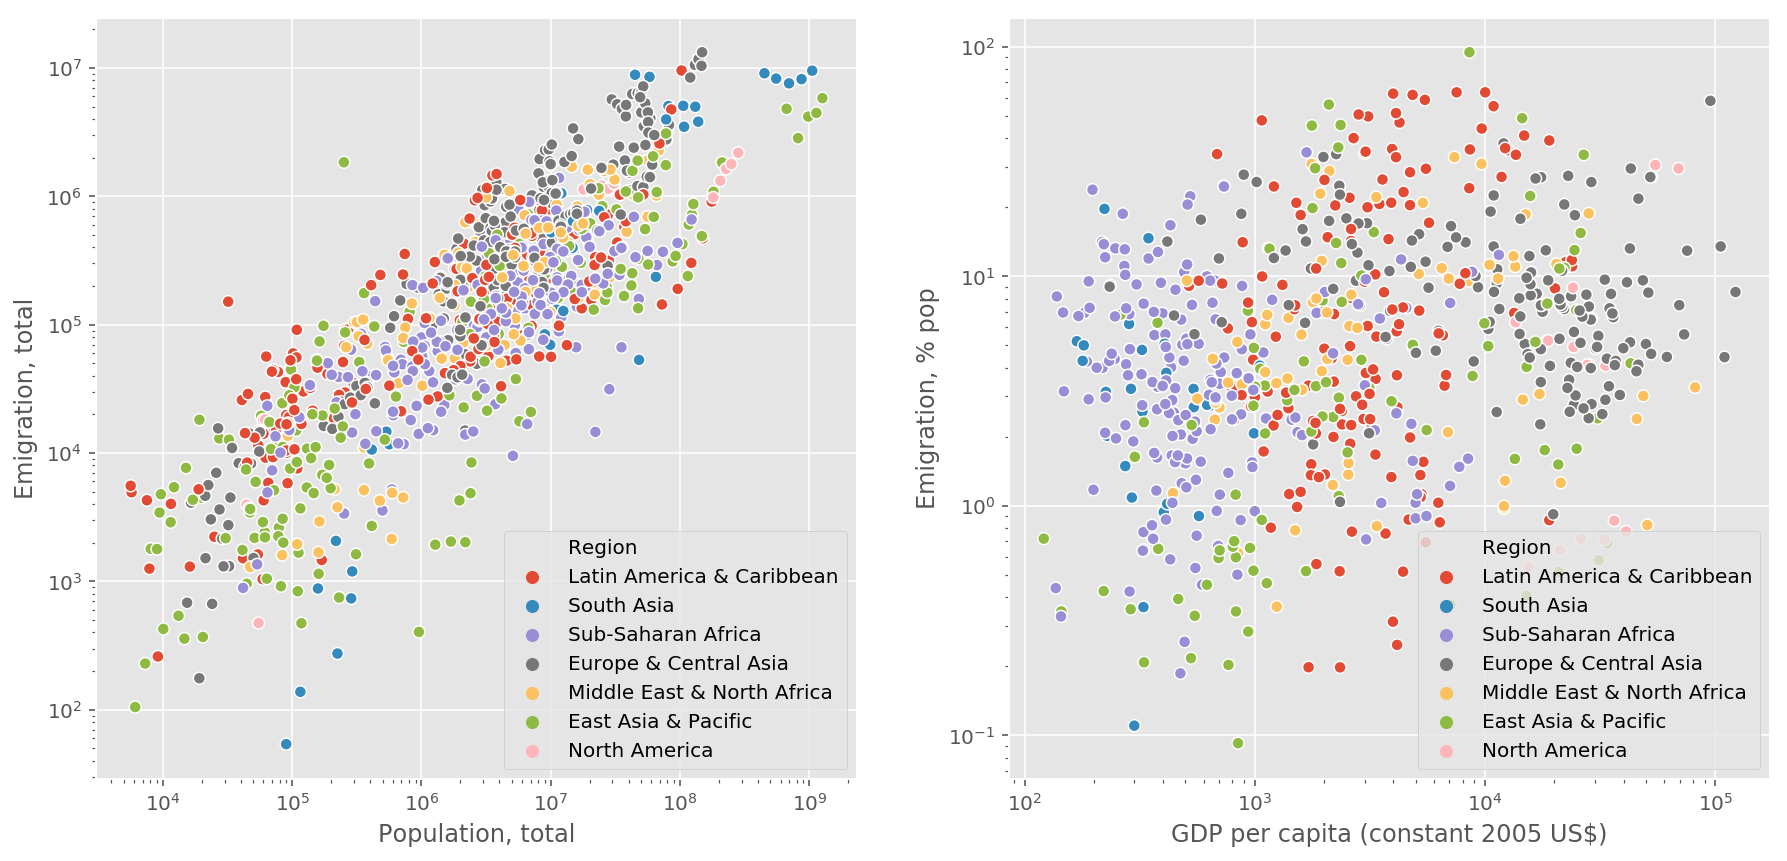

In [109]:
plt.figure(figsize=(15,7))
plt.subplot(121)
plot1 = sns.scatterplot(data=data_set,y='Emigration, total',x='Population, total',hue='Region' )
plot1.set_xscale('log')
plot1.set_yscale('log')
plt.legend(loc='lower right')

plt.subplot(122)
plot1 = sns.scatterplot(data=data_set,y='Emigration, % pop',x='GDP per capita (constant 2005 US$)',hue='Region' )
plot1.set_xscale('log')
plot1.set_yscale('log')
plt.legend(loc='lower right')

____
The larger the country, the larger the emigration. Intuitive. Still countries of same dimension 1-2 orders of magnitude of difference in emigration. See also the general increase of emigration over the year. Let's also see the difference by Region

Middle level countries have a larger share of emigration. Economic conditions, however, explain only partially the migration process. It looks that poorest countries (GDP per capita less than 2000 suffer of a "poverty-trap" effect.

The division by region shows that 

### Cleaning the WB dataset
The World Bank indicators dataset is not ready-to-use. It contains an very large number of missing data. 

In [49]:
data_set.isnull().sum()
print('The null values are ' + str(data_set.shape) + ' for indicators and country, respectively')

The null values are (1015, 1144) for indicators and country, respectively


Text(0,0.5,'Number of Indicators')

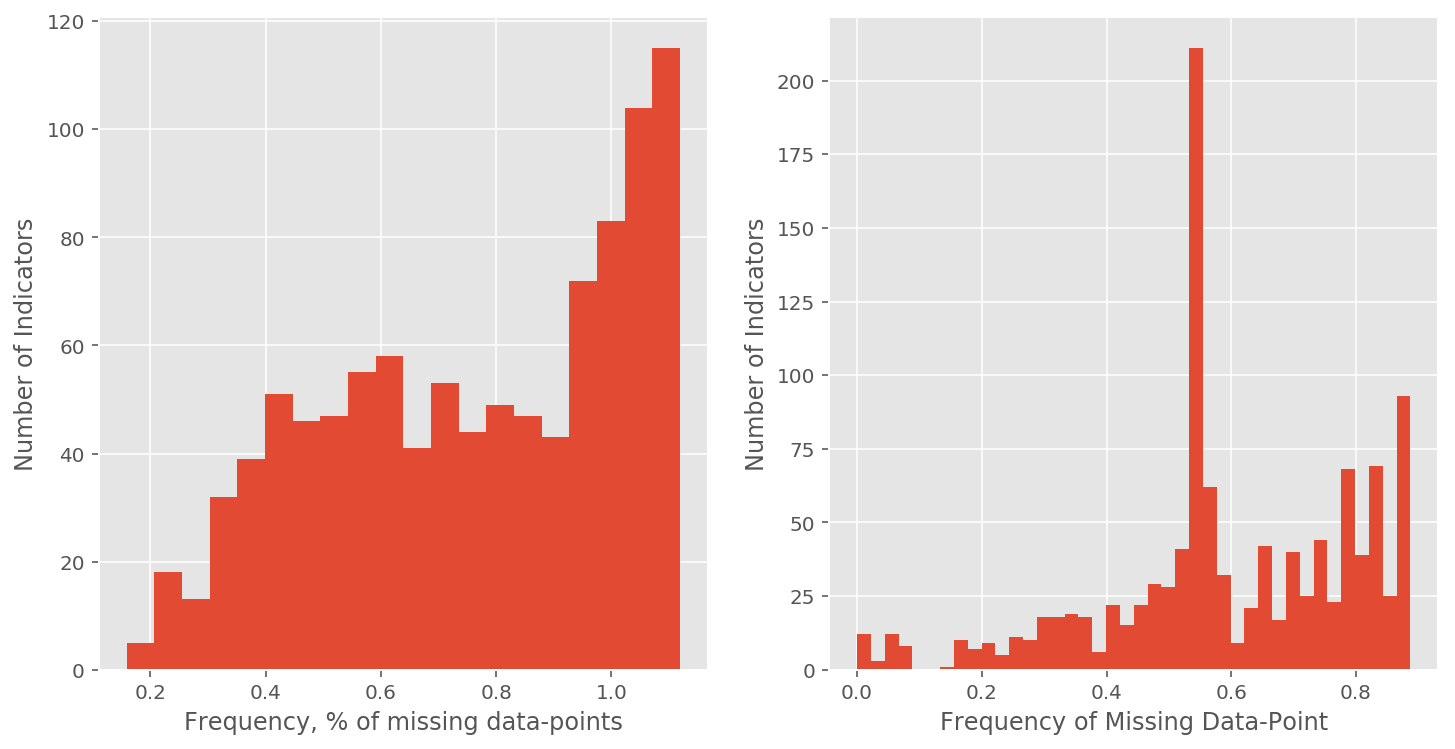

In [50]:
# statistics on missing data
plt.subplot(121)
plt.hist(data_set.isnull().sum(1).values/data_set.shape[0],bins=20)
plt.ylabel('Number of Indicators')
plt.xlabel('Frequency, % of missing data-points')
plt.subplot(122)
plt.hist(data_set.isnull().sum()/data_set.shape[1],bins=40)
plt.xlabel('Frequency of Missing Data-Point')
plt.ylabel('Number of Indicators')

There are data-points that are poorly populated. These should also be removed.

The function smart_cut drops rows and columns with a large number of missing data, until a small percentage of missing value, considered acceptable is reached. The wheight modulates the importance of keeping columns. Since we prefer to have more datapoints than indicators, we will set this parameter at a value lower than 1 (more weights to data-points) 

In [51]:
from migration import smart_cut, order_by_nan,sel_regressor    

threshold = 0.10
weight_ind = 0.1
data_set_cut = smart_cut(data_set,threshold,weight_ind)

In [52]:
print('\n \n Using these parameters, we keep ' + str(data_set_cut.shape[0]) + ' datapoints and '+ 
      str(data_set_cut.shape[1]-2) + ' indicators \n')


 
 Using these parameters, we keep 794 datapoints and 112 indicators 



Below the retained indicators, and the number of missing values.

We now fill the remaining missing data with the median of its columns. 

In [53]:
data_set_cut = data_set_cut.fillna(data_set_cut.median())

Delete of LCU, Local current unit. Make little sense. 


In [54]:
containts_LCU = [s for s in data_set_cut.columns if 'LCU' in s]
data_set_cut = data_set_cut.drop(containts_LCU, axis=1)

We now have a clean usable dataset.

### Feature Engineering

##### Work on the log()
As seen in plots above, it makes more sense to work on the log transform. This is true for most of the indicators, including the target variable. See plot below. 

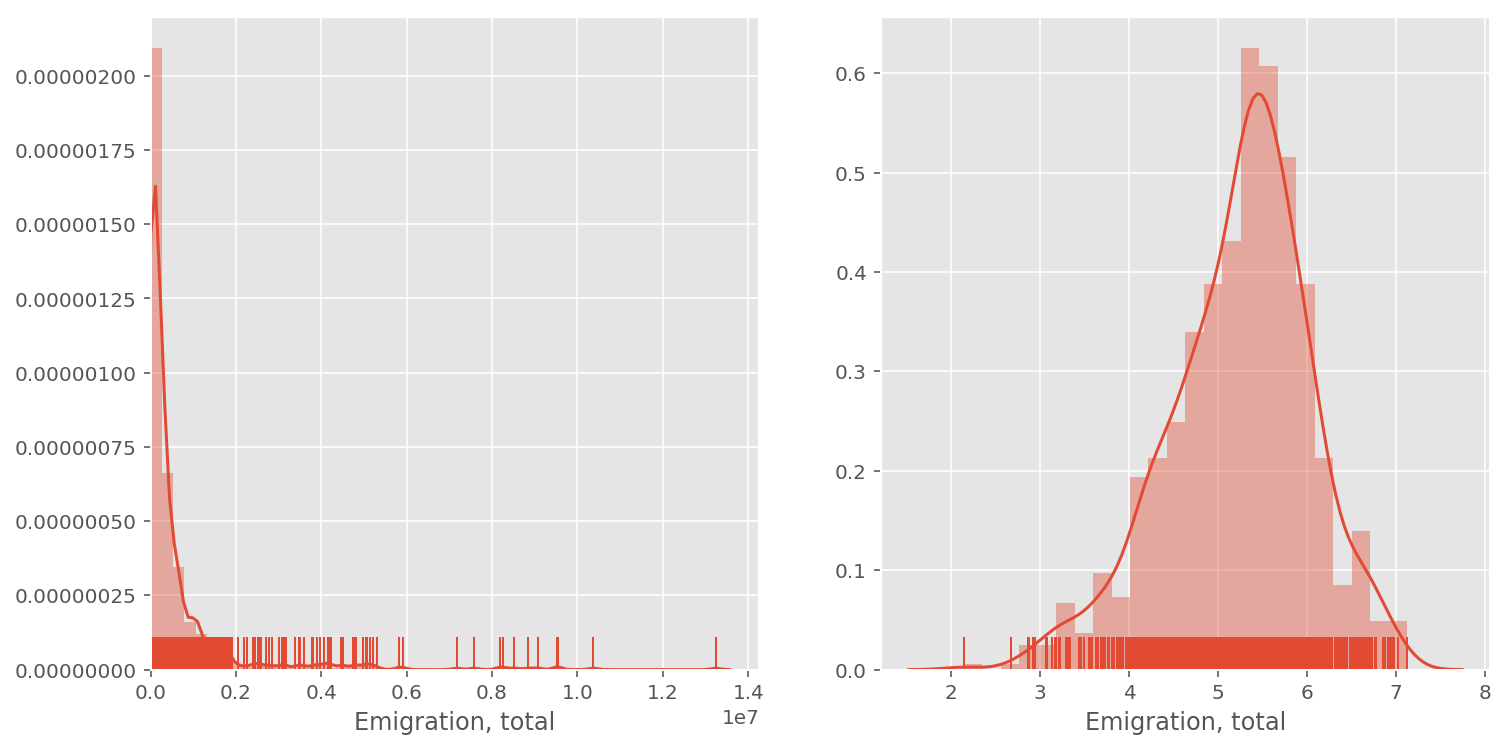

In [55]:
plt.subplot(121)
sns.distplot(data_set_cut['Emigration, total'],rug=True)
plt.xlim(0)
plt.subplot(122)
sns.distplot(np.log10(data_set_cut['Emigration, total']),rug=True)

Much skewed distribution. A model using these data would be dominated by the few extreme values. We transform the data, log ()

Much better shaped distribution. 

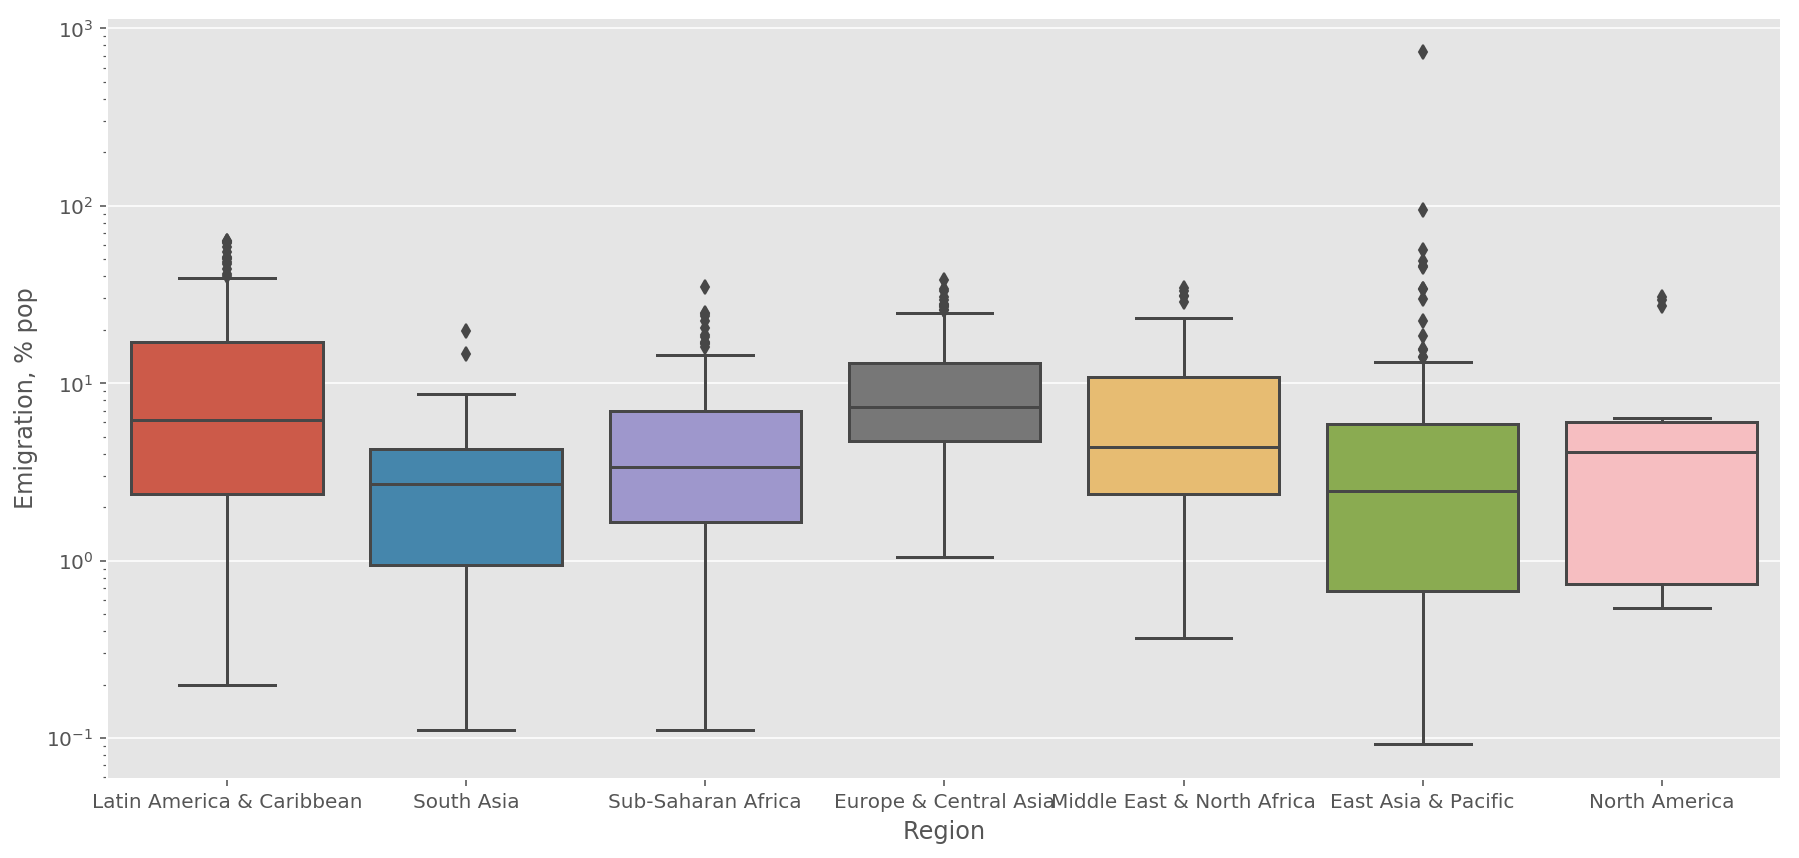

In [56]:
plt.figure(figsize=(15,7))
plot1 = sns.boxplot(data=data_set_cut,x='Region',y='Emigration, % pop')
plot1.set_yscale('log')


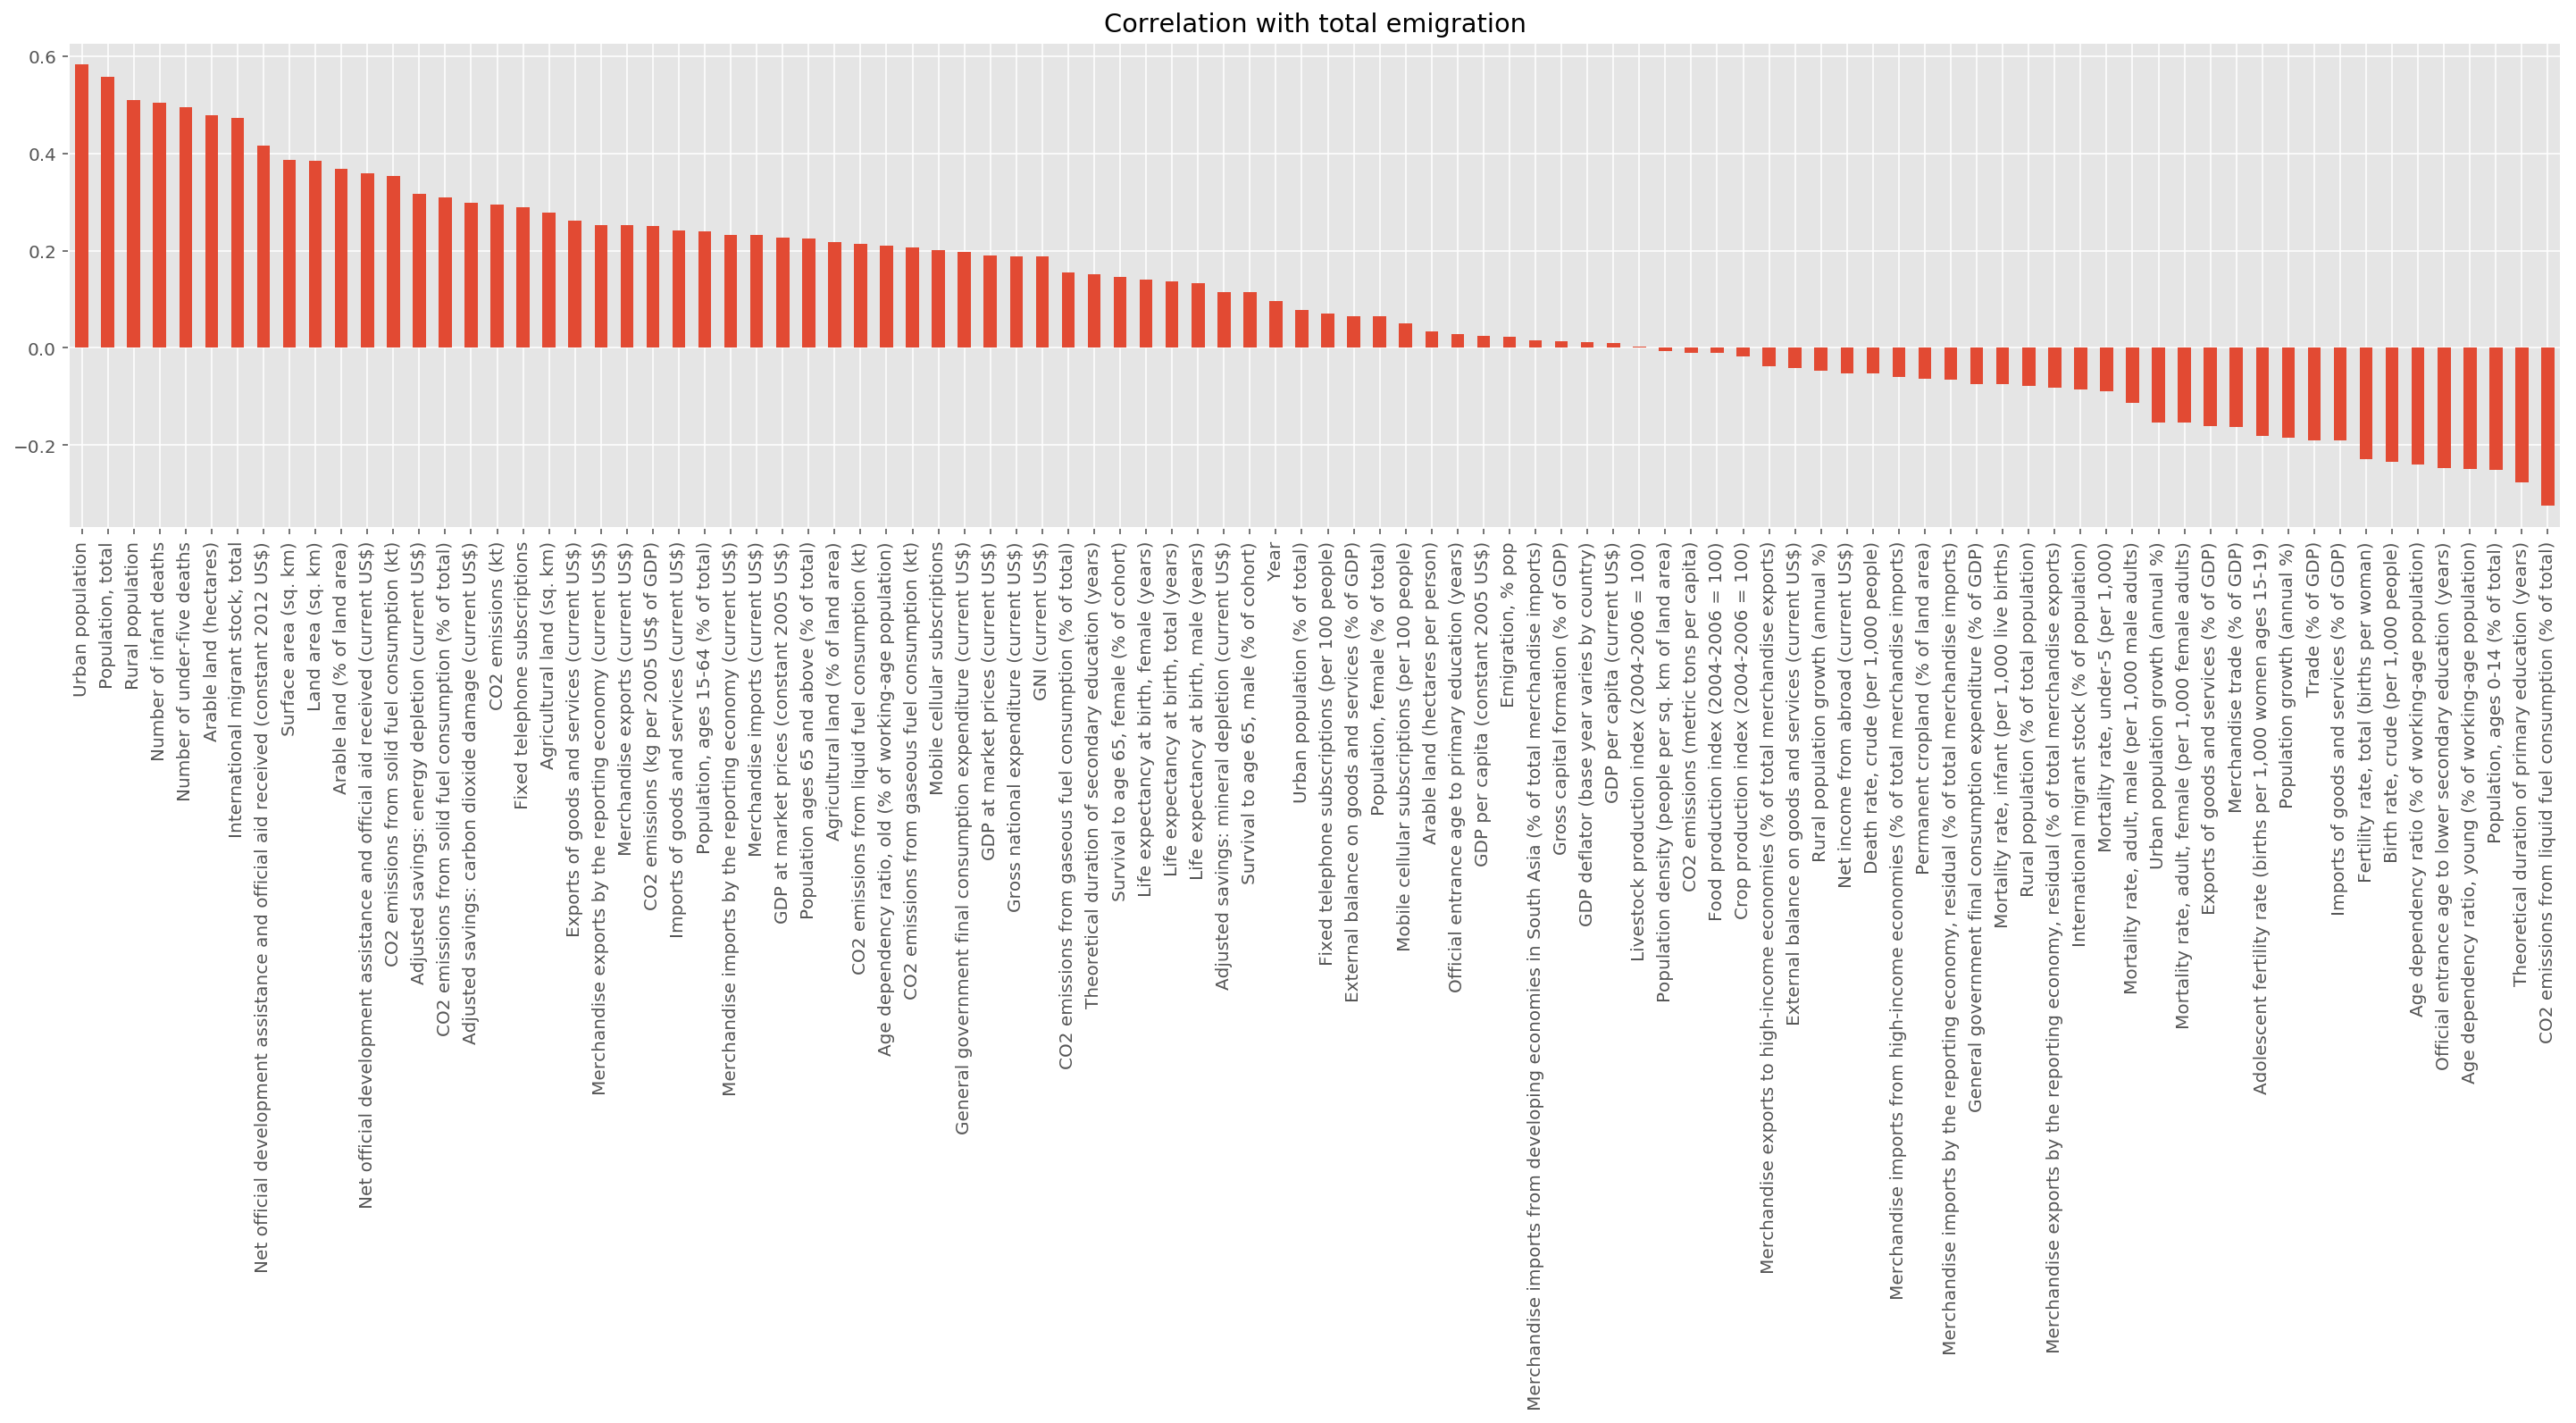

In [57]:
data_set_cut.corr()['Emigration, total'].drop('Emigration, total').sort_values(ascending=False).plot(kind='bar',figsize=(25,5),title='Correlation with total emigration')

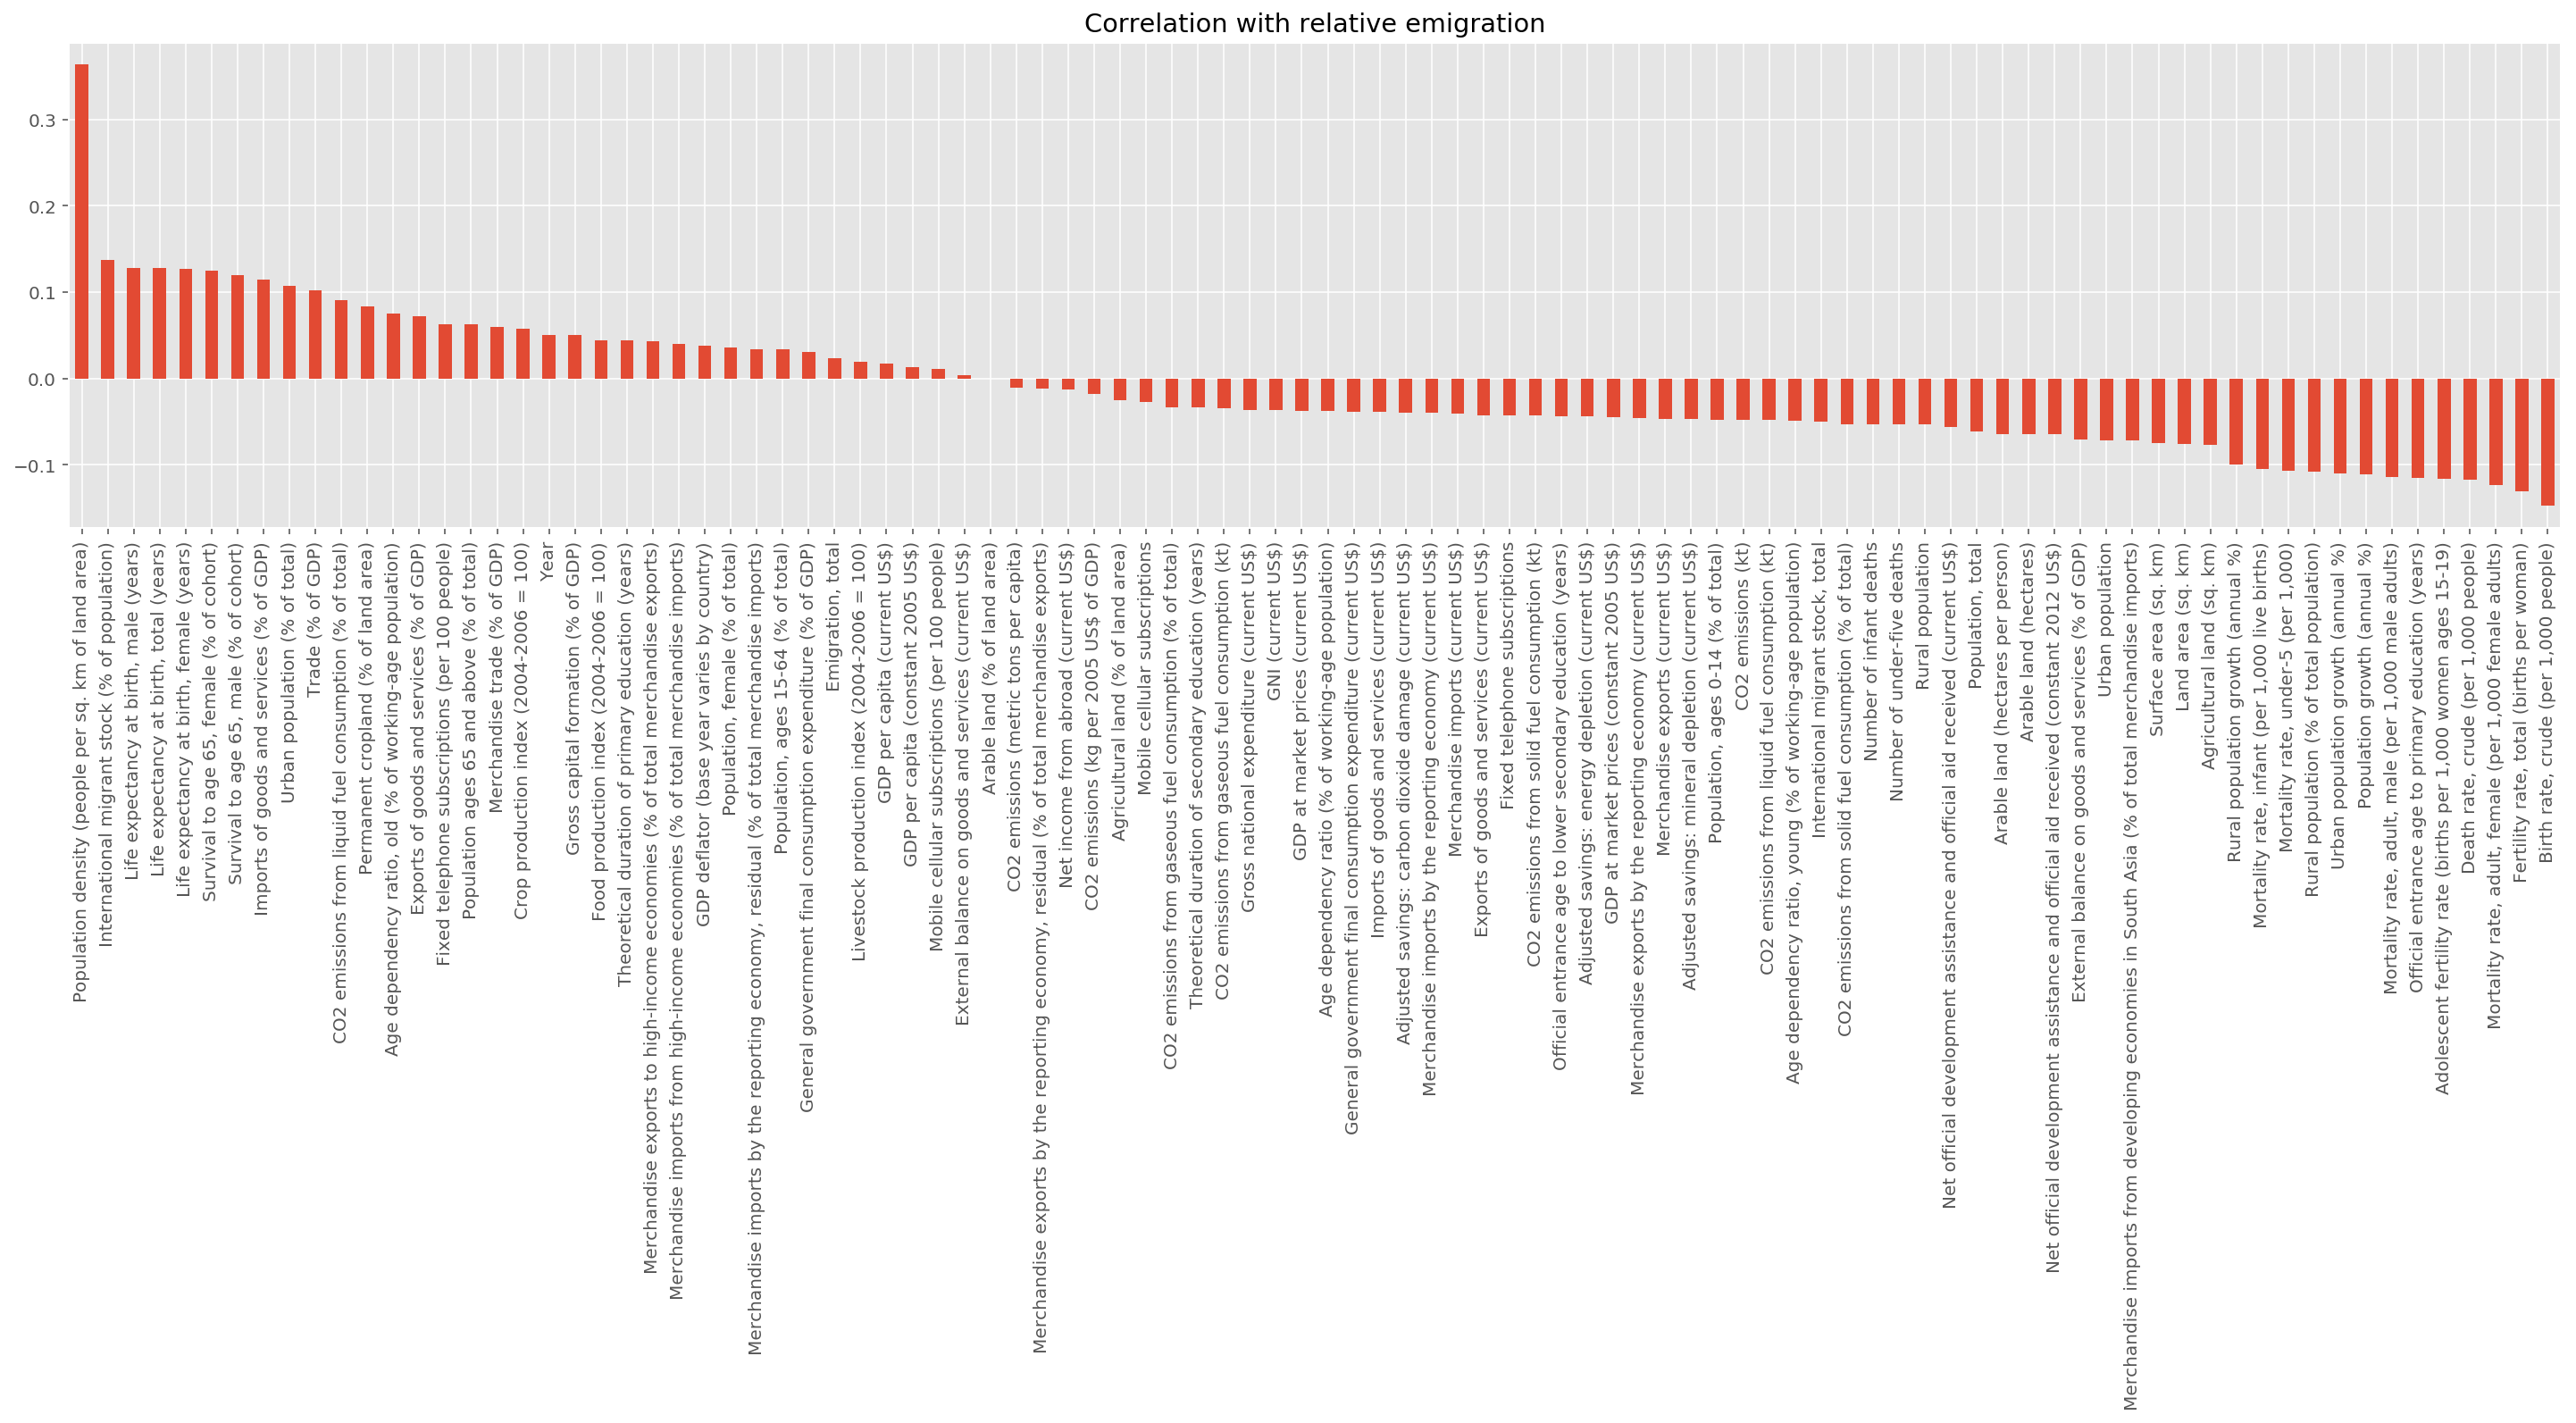

In [58]:
data_set_cut.corr()['Emigration, % pop'].drop('Emigration, % pop').sort_values(ascending=False).plot(kind='bar',figsize=(25,5),title='Correlation with relative emigration')

[]

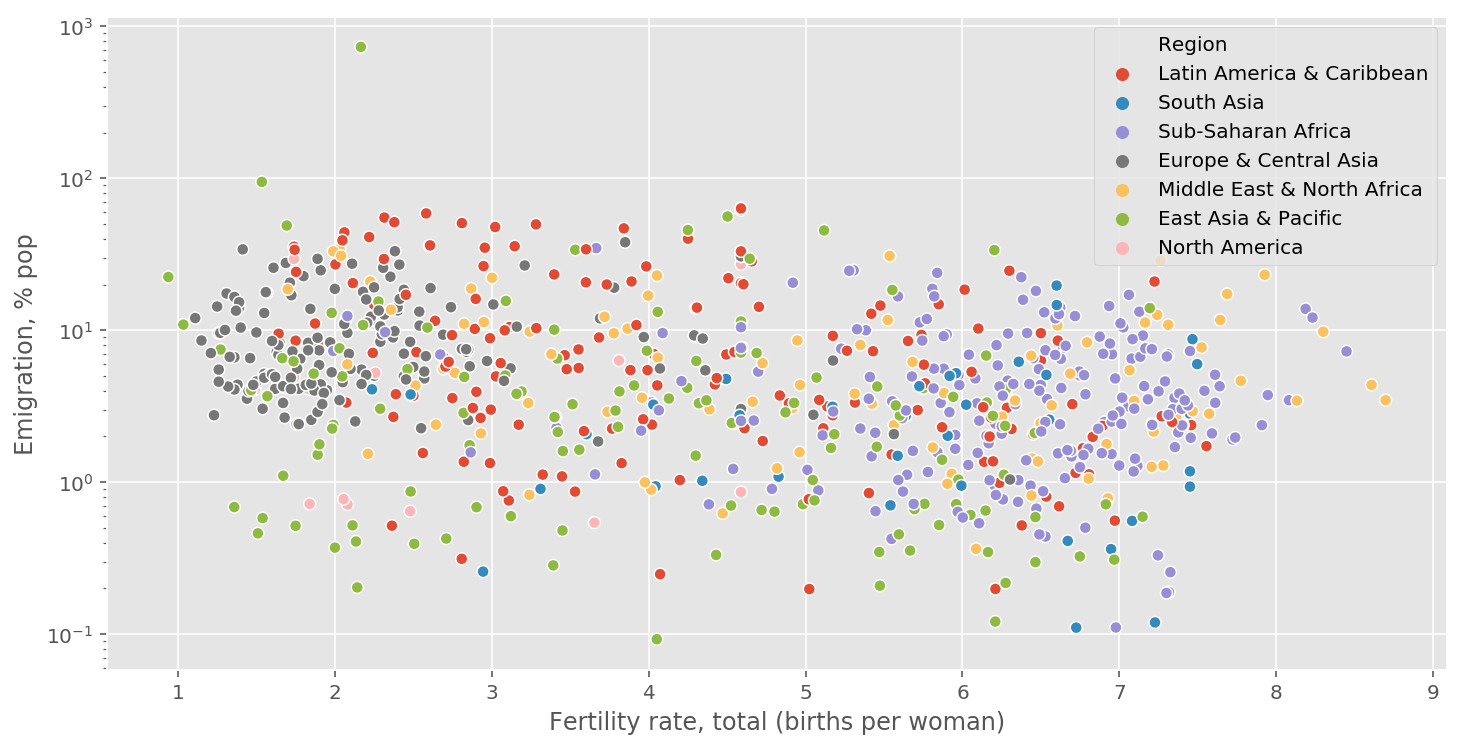

In [59]:
sns.scatterplot(data=data_set_cut,y='Emigration, % pop',x='Fertility rate, total (births per woman)',hue='Region').semilogy()#,hue='Region')

Presence of a weak negative signal, seems not depending on region. 

Meaning for feature engineering: do not use log, but the original indicator. We will keep both and leave the feature selection to the algorithm. 

In [60]:
data = data_set_cut.drop(['CountryCode','Region'],axis=1)

data_log = pd.DataFrame()
for column in data:
    if all(data[column]>0):
        data_log['Log of '+column] = data[column].apply(np.log10)
   

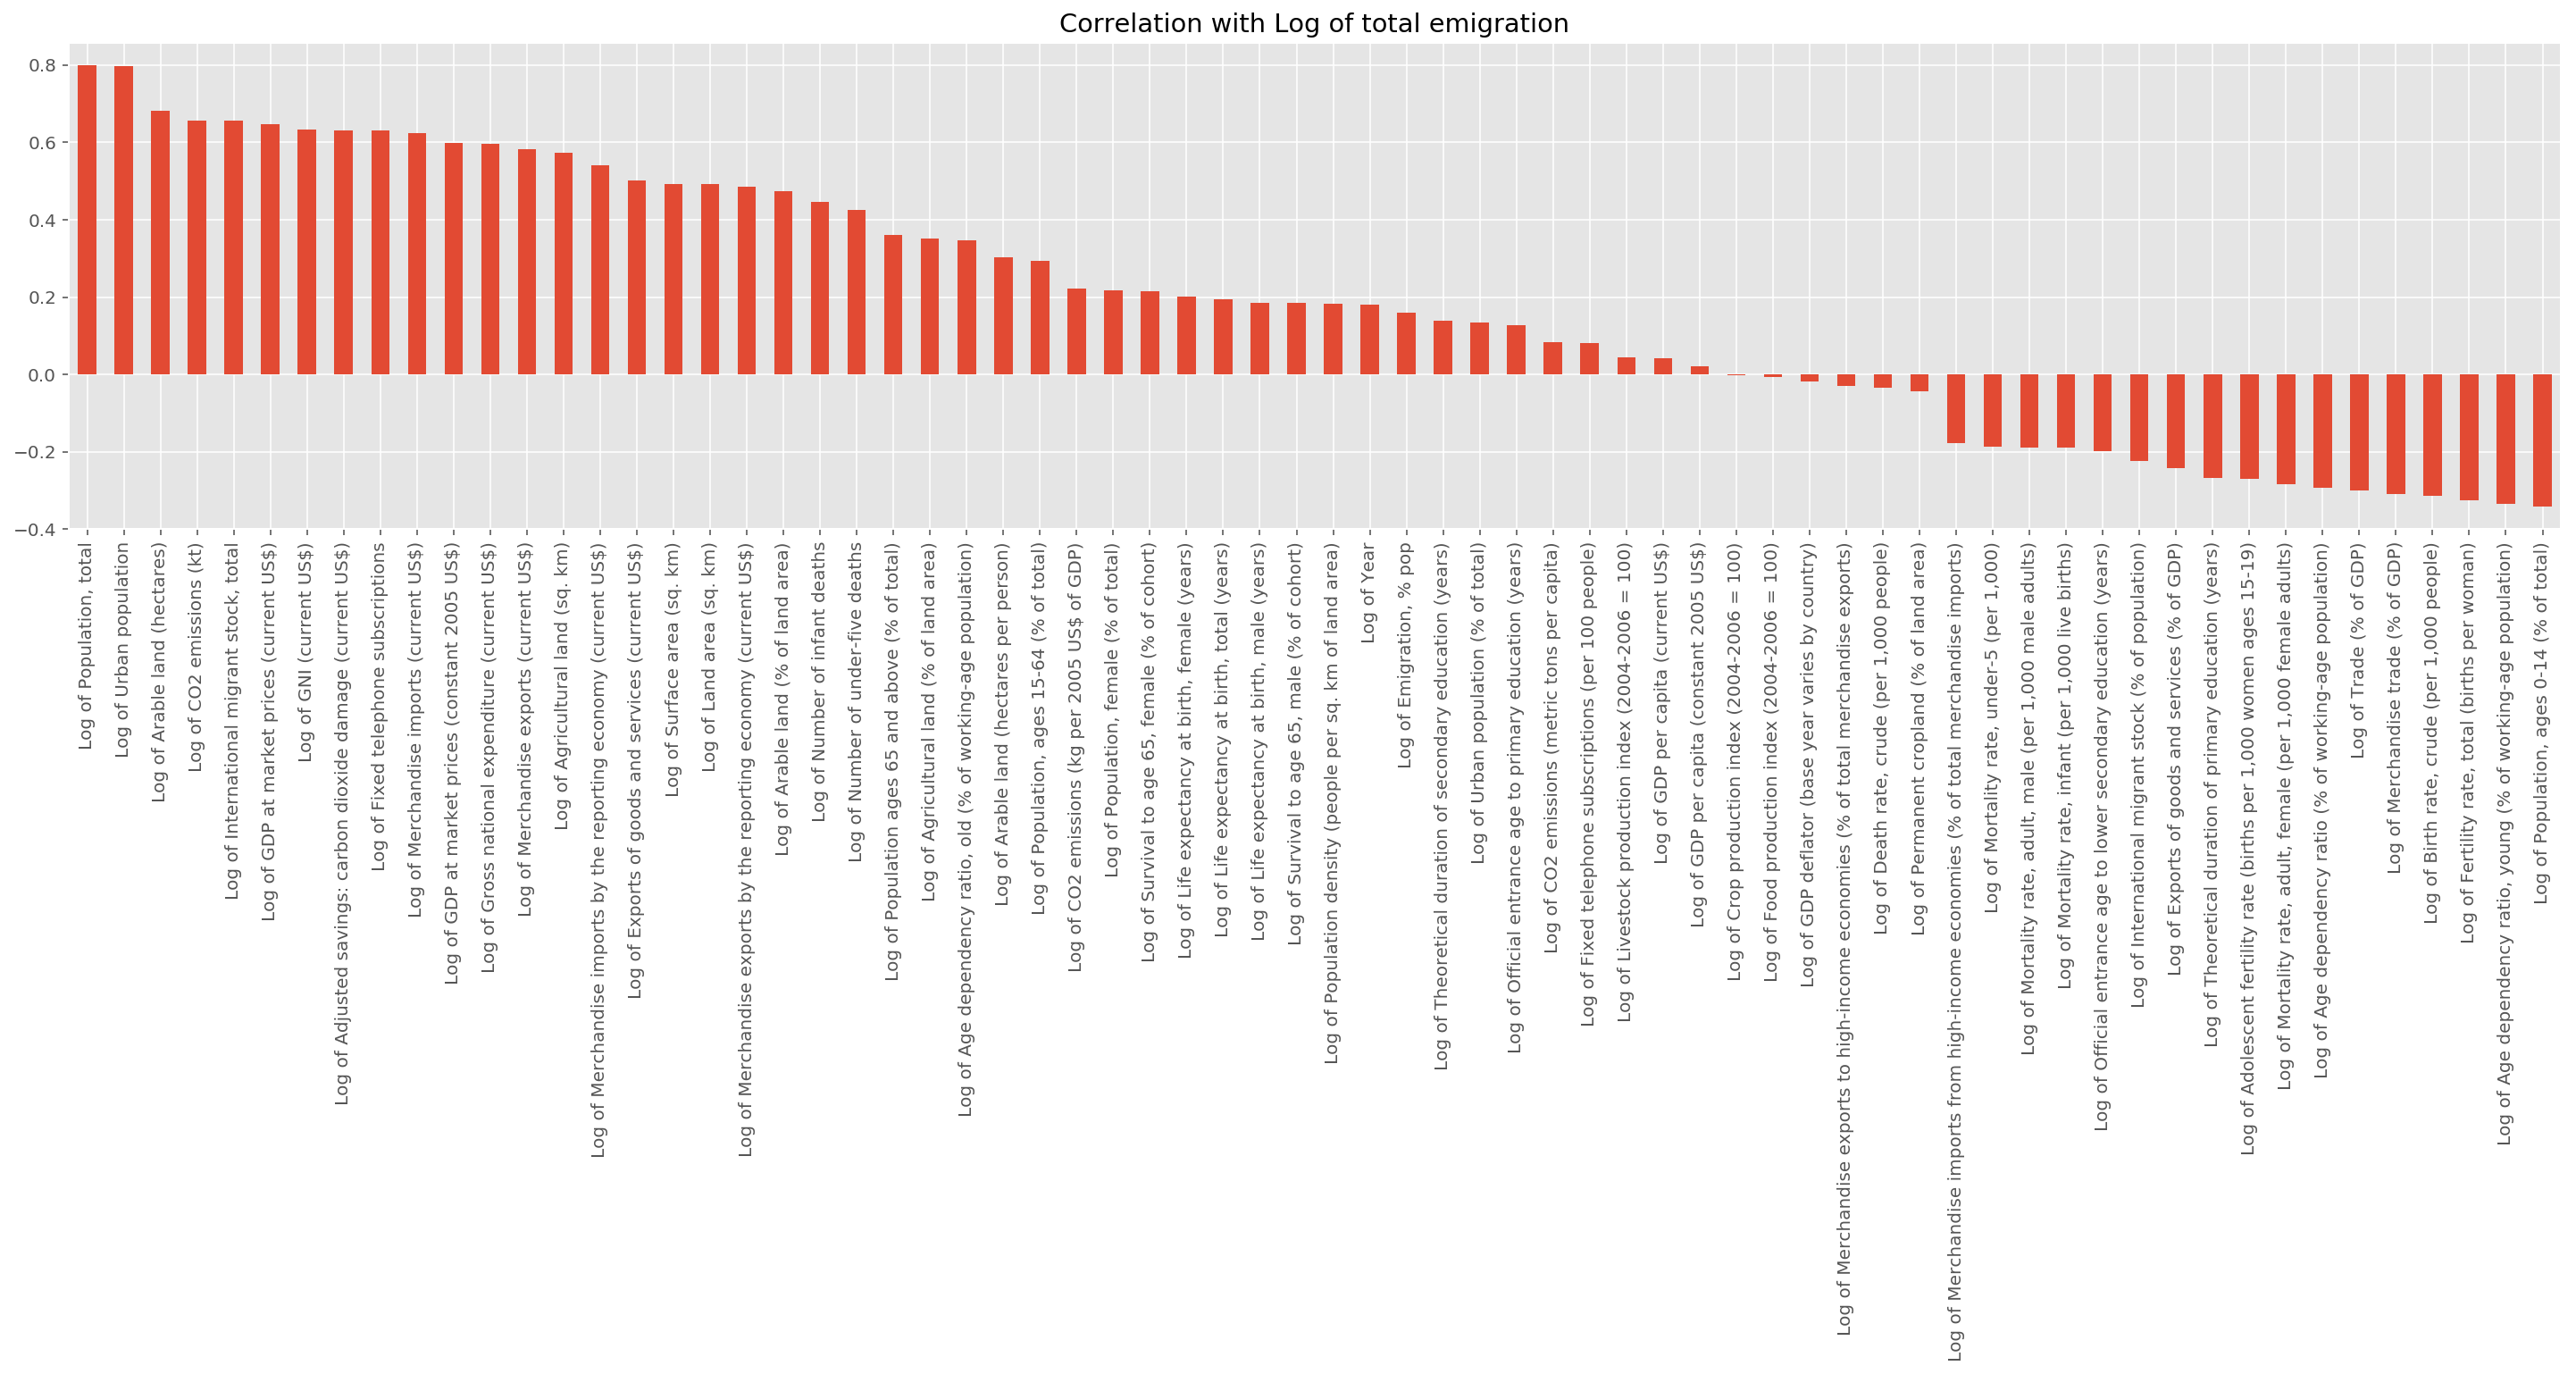

In [62]:
data_log.corr()['Log of Emigration, total']\
.drop('Log of Emigration, total')\
.sort_values(ascending=False)\
.plot(kind='bar',figsize=(25,5),title='Correlation with Log of total emigration')

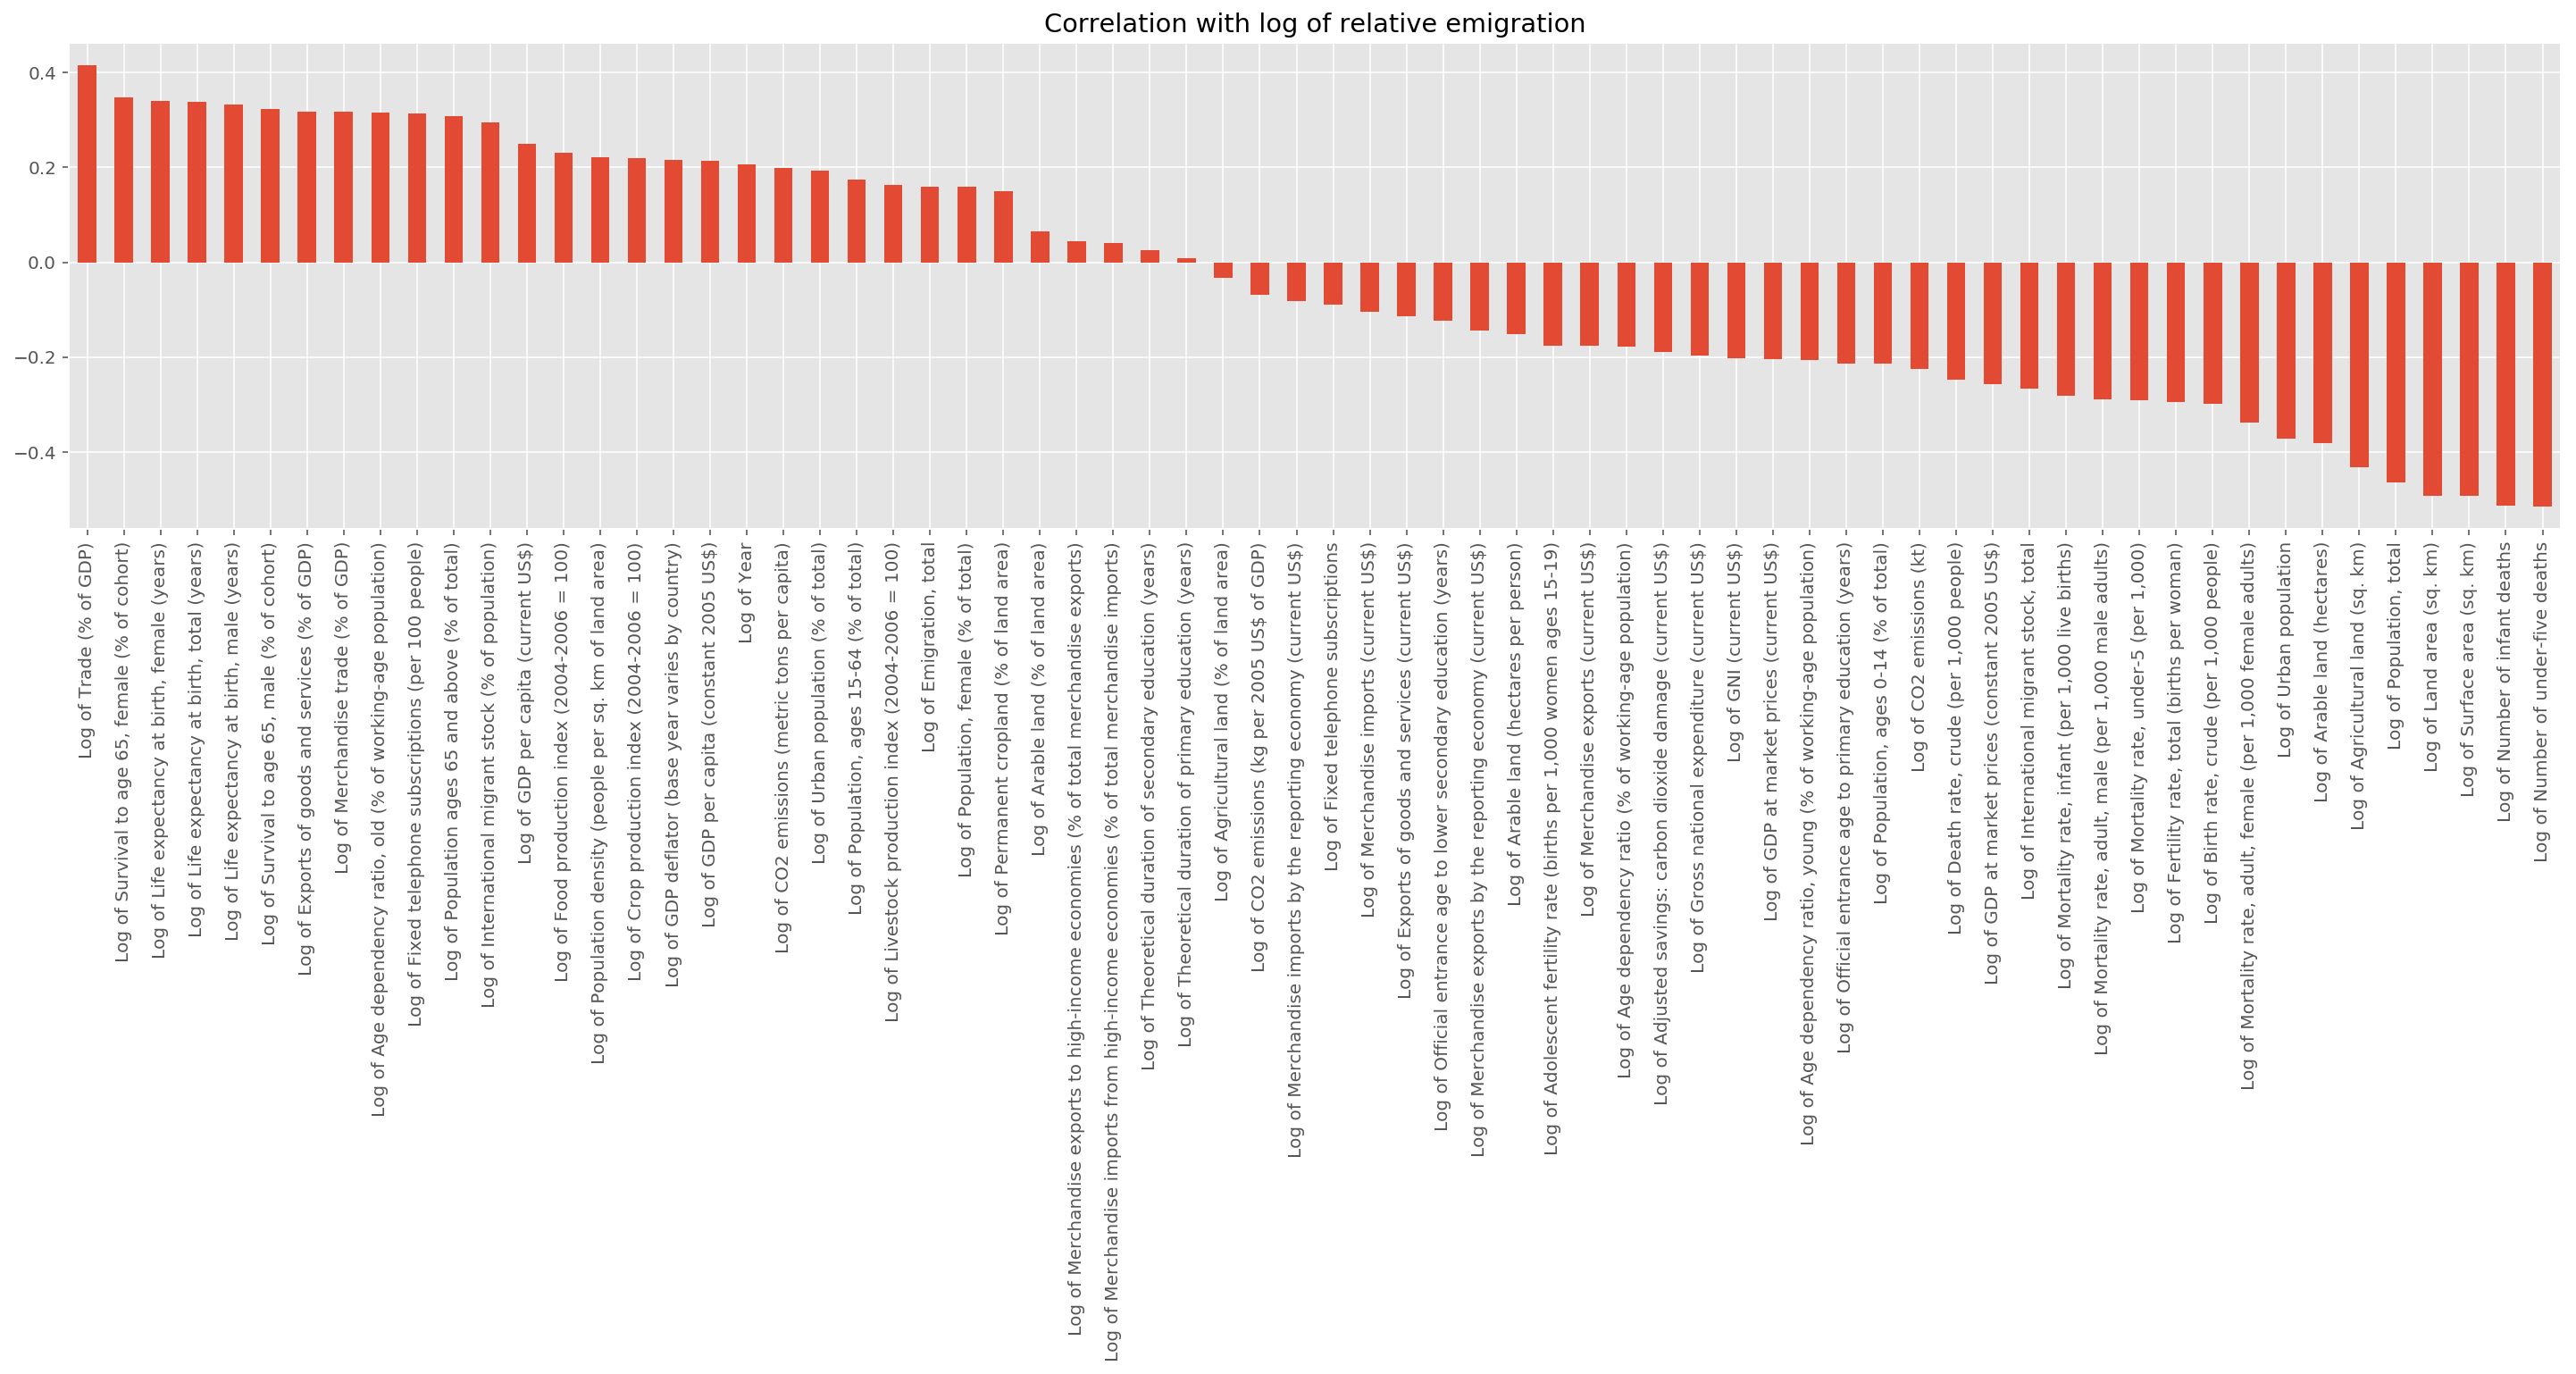

In [111]:
data_log.corr()['Log of Emigration, % pop'].drop('Log of Emigration, % pop').sort_values(ascending=False).plot(kind='bar',figsize=(25,5),title='Correlation with log of relative emigration')


In [121]:
data_log['Surface, size class'] = pd.cut(data_log['Log of Surface area (sq. km)'],bins=3,labels=['small','medium','large'])

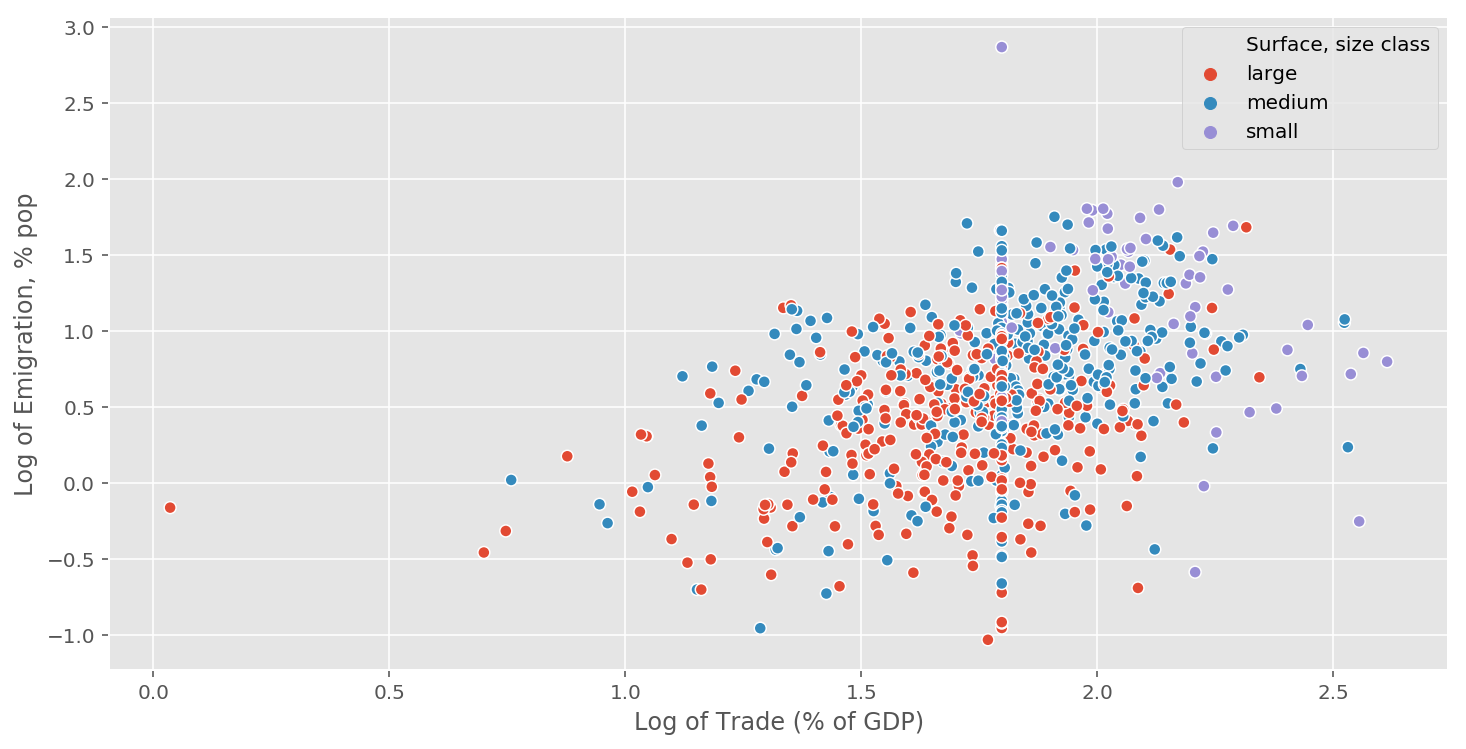

In [122]:
sns.scatterplot(data=data_log,y='Log of Emigration, % pop',x='Log of Trade (% of GDP)',hue='Surface, size class')

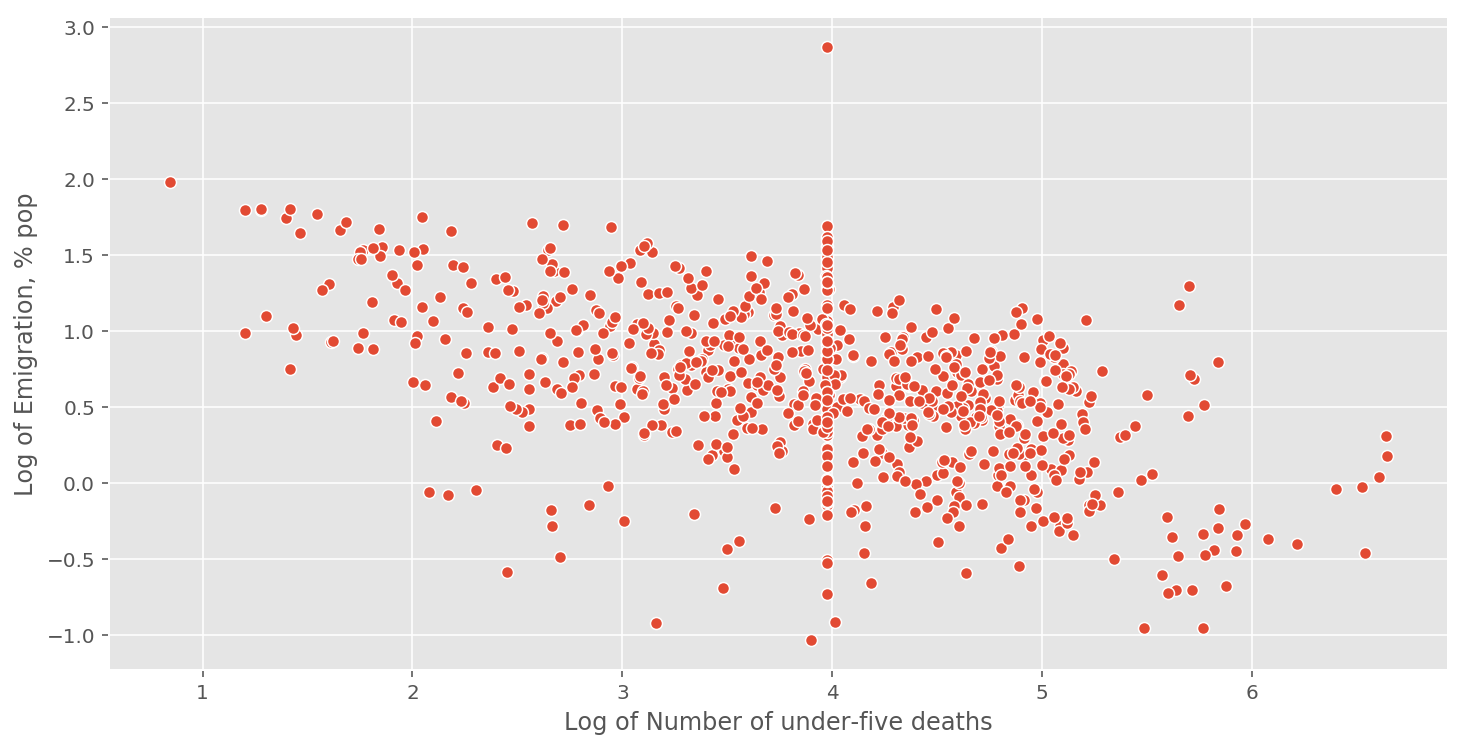

In [114]:
sns.scatterplot(data=data_log,y='Log of Emigration, % pop',x='Log of Number of under-five deaths')

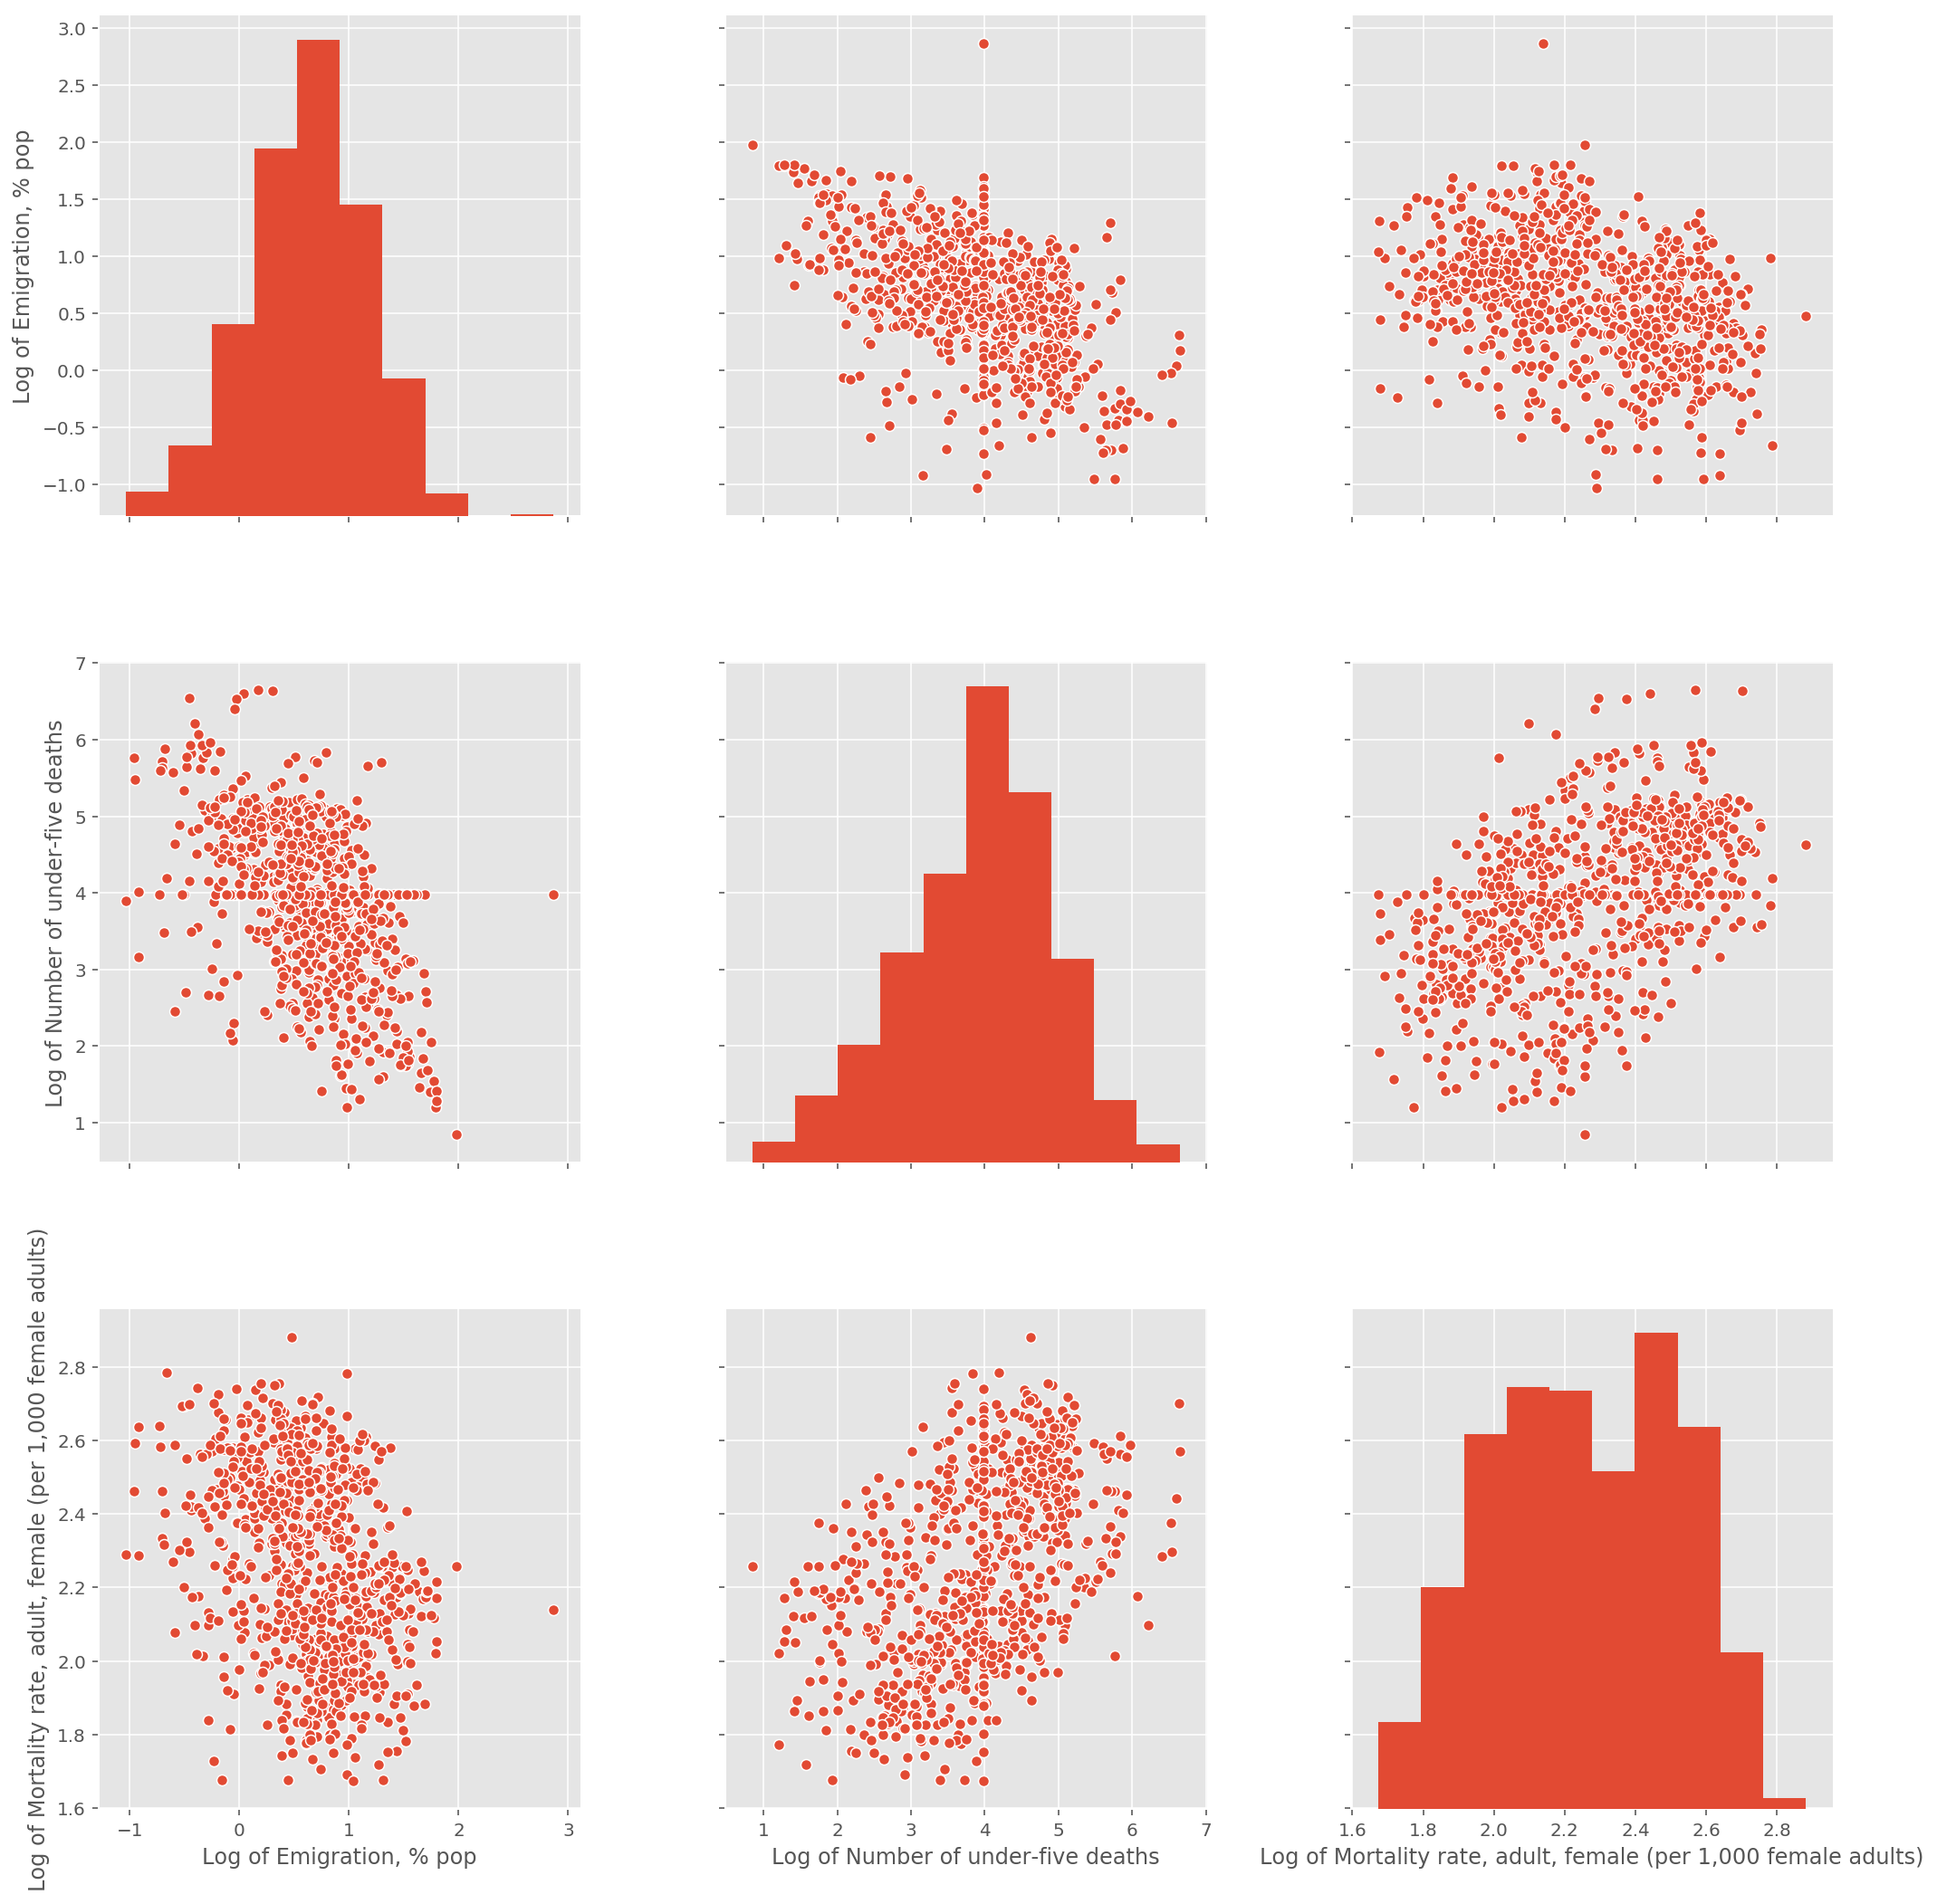

In [115]:
sns.pairplot(data_log[['Log of Emigration, % pop','Log of Number of under-five deaths','Log of Mortality rate, adult, female (per 1,000 female adults)']],height=5)


## The issue of correlation
Many indicators appear to be well correlated with one or more other indicators. Both by their definition, or because of a common causal effect. 

Effect on modeling. 
This is an issue that deserve further investigation. 
We explore the distance betweeen indicators. log. 
We use a xx metric, and a xx method. 

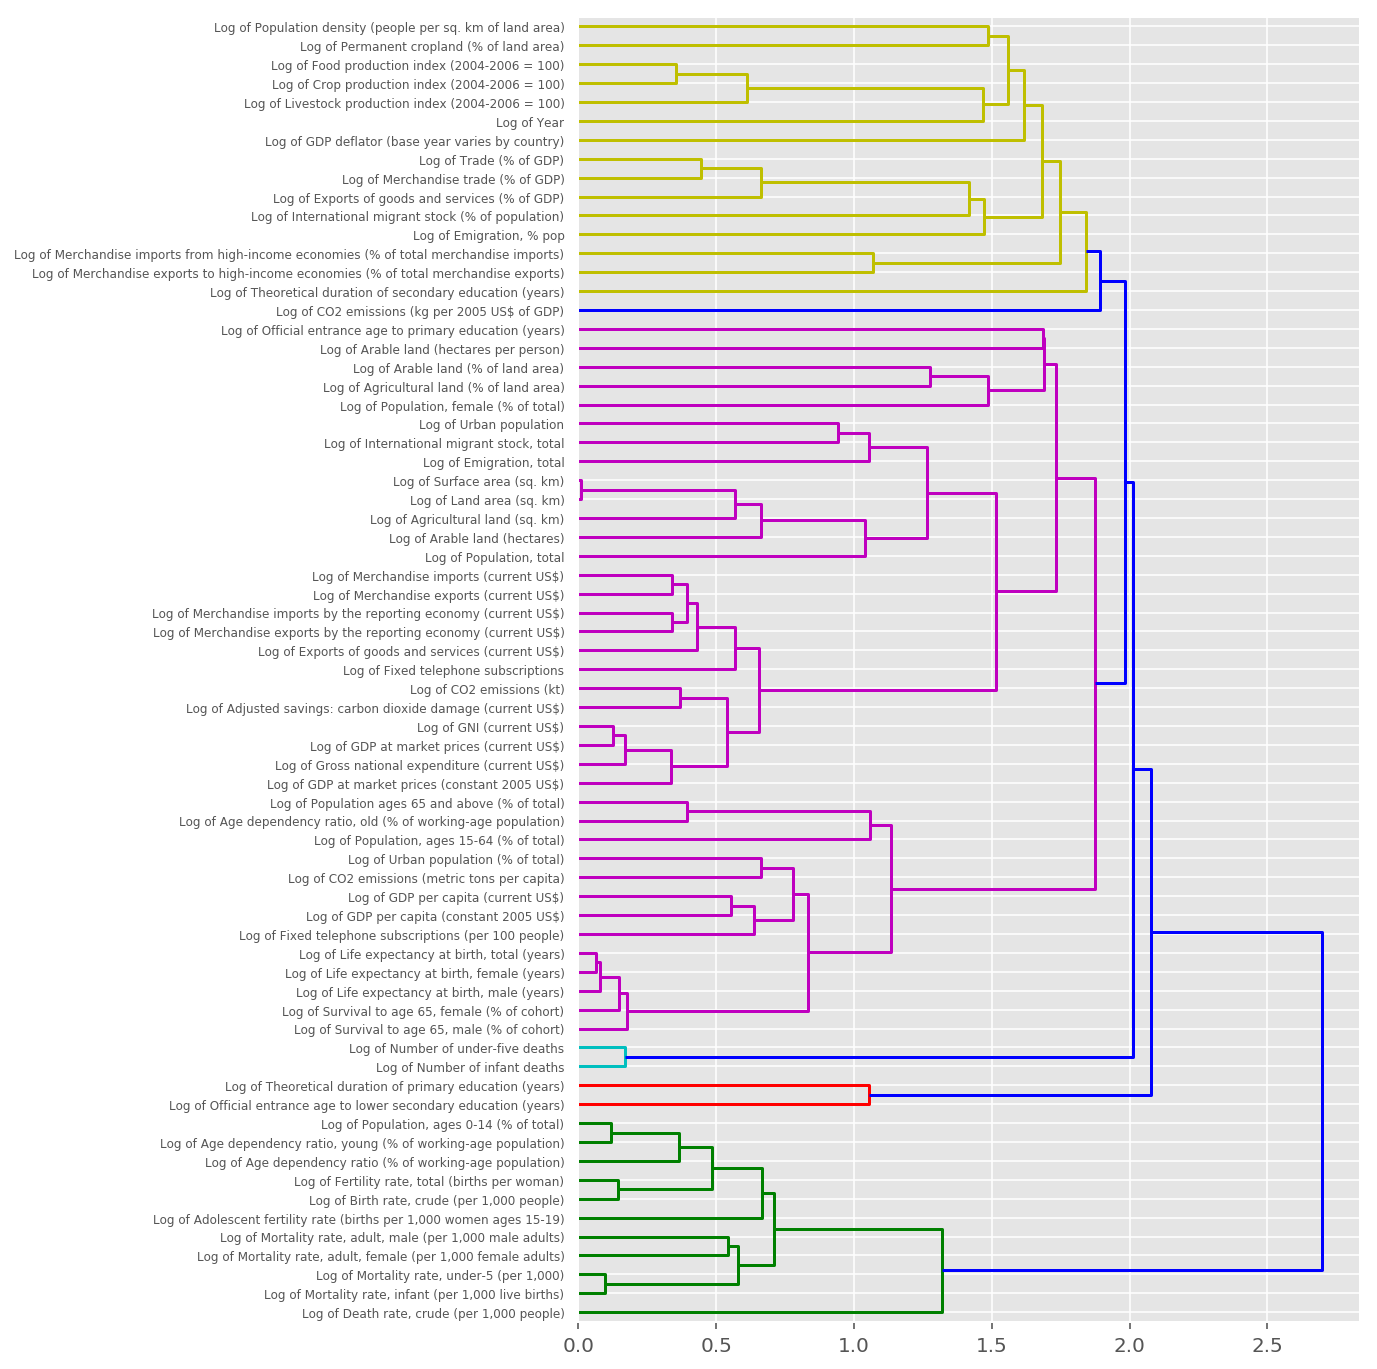

In [78]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(data_log.corr(),method='single',metric='euclidean')
plt.figure(figsize=(7,12))
dn = dendrogram(Z,orientation='right',truncate_mode=None,distance_sort='descendent',labels=data_log.corr().index)

____
The graph above. 
Comments. 
This will be very important in the modeling phase. 

In [76]:
# Save data 
data_tot = data_set_cut.join(data_log,how='outer')
data_tot.to_csv('data/emigration_indicators_data.csv',index=False)